# Trajectory Generation via Sequential Convex Programming tutorial (SCvx and GuSTO)

**Author: PhD Candidate, Franklin Josue Ticona Coaquira**
*ticona.franklin6015@mail.kyutech.jp, franklinticona10mfq@gmail.com*


<center><img src="https://media1.tenor.com/m/CwEI_MIV8fEAAAAd/hello-panda.gif" width="300"></center>


Requirements:

**Core numerical libraries:**

numpy, scipy

**Optimization:**

cvxpy, cvxpygen, ecos, osqp


**Visualization:**

matplotlib, plotly

# Basic example introduction (PTR)

This basic example aims to solve the following **drone trajectory planning problem** using **Sequential Convex Programming**:

$$
\begin{aligned}
\min \quad &\int_{0}^{t_f}\|\mathbf{a}(t)\|_2^2\,dt\\[6pt]
\text{s.t.}\quad
&\ddot{\mathbf{r}}(t)=\mathbf{a}(t)-g
\begin{bmatrix}
0\\
0\\
1
\end{bmatrix}\\[6pt]

&\|\mathbf{a}(t)\|_2\le a_{max}\\[6pt]

&\mathbf{r}(0)=\mathbf{r}_{init},\quad
\dot{\mathbf{r}}(0)=\mathbf{v}_{init}\\[6pt]

&\mathbf{r}(t_f)=\mathbf{r}_{final},\quad
\dot{\mathbf{r}}(t_f)=\mathbf{v}_{final}\\[6pt]

&\|\mathbf{r}(t)-\mathbf{c}_j\|_2\ge d_{obs},
\quad j=1,\dots,n_{obs}
\end{aligned}
$$

Kinematic diagram:

<center>
<img src="https://i.ibb.co/jLPrB7z/dron.png" width="600">
</center>

The state–space representation is given by

\begin{equation*}
\begin{bmatrix}
\ddot{x}\\
\ddot{y}\\
\ddot{z}\\
\dot{x}\\
\dot{y}\\
\dot{z}
\end{bmatrix}
=\begin{bmatrix}
0&0&0&0&0&0\\
0&0&0&0&0&0\\
0&0&0&0&0&0\\
1&0&0&0&0&0\\
0&1&0&0&0&0\\
0&0&1&0&0&0
\end{bmatrix}
\begin{bmatrix}
\dot{x}\\
\dot{y}\\
\dot{z}\\
x\\
y\\
z
\end{bmatrix}
+
\begin{bmatrix}
1&0&0\\
0&1&0\\
0&0&1\\
0&0&0\\
0&0&0\\
0&0&0
\end{bmatrix}
\begin{bmatrix}
a_x\\
a_y\\
a_z-g
\end{bmatrix}
\end{equation*}

Thus,

\begin{equation*}
\mathbf{A}(t)=
\begin{bmatrix}
0&0&0&0&0&0\\
0&0&0&0&0&0\\
0&0&0&0&0&0\\
1&0&0&0&0&0\\
0&1&0&0&0&0\\
0&0&1&0&0&0
\end{bmatrix},
\quad
\mathbf{B}(t)=
\begin{bmatrix}
1&0&0\\
0&1&0\\
0&0&1\\
0&0&0\\
0&0&0\\
0&0&0
\end{bmatrix}
\end{equation*}


\begin{equation}
\dot{\textbf{x}}=\textbf{A}\textbf{x}+\textbf{B}\textbf{a}+\begin{bmatrix}
0\\
0\\
-g\\
0\\
0\\
0
\end{bmatrix}
\end{equation}

# Basic Discretization

## Basic Integral discretization

The integral:

\begin{equation}
\int_{0}^{t_f}||\textbf{a}(t)||_2^2dt
\end{equation}

Can be approximate via Riemman Series:

\begin{equation}
\int_{0}^{t_f}||\textbf{a}(t)||_2^2dt≈\sum_{i=0}^{T}\tau\cdot ||\textbf{a}_i||^2=\tau\sum_{i=0}^{T}\cdot ||\textbf{a}_i||^2
\end{equation}
Nota that:

\begin{equation}
\textbf{a}_i≜\textbf{a}(\tau\cdot i)
\end{equation}

## Basic State space discretization

Let the general **Linear Time-Varying (LTV) system** be

\begin{equation}
\dot{\mathbf{x}}(t)=\mathbf{A}(t)\mathbf{x}(t)+\mathbf{B}(t)\mathbf{u}(t)
\end{equation}


For a time interval $ t \in [t_k,t_{k+1}] $, the exact solution for $ \mathbf{x}(t) $ is given by

\begin{equation}
\mathbf{x}(t)=\Phi(t,t_k)\mathbf{x}(t_k)
+\int_{t_k}^{t}\Phi(t,\xi)\mathbf{B}(\xi)\mathbf{u}(\xi)d\xi
\end{equation}

Assume that $ \mathbf{A}(t) $ and $ \mathbf{B}(t) $ are constant matrices and a **zero-order hold (ZOH)** condition is applied, implying that $ \mathbf{u}(t_k) $ remains constant in the interval $ [t_k,t_{k+1}] $.

Therefore, evaluating the solution at $ t_{k+1} $ yields

\begin{equation}
\mathbf{x}(t_{k+1})
=e^{\mathbf{A}(t_{k+1}-t_k)}\mathbf{x}(t_k)
+
\Bigg(\int_{0}^{t_{k+1}-t_k}e^{\mathbf{A}(t_{k+1}-t_k-\xi)}d\xi\Bigg)\mathbf{B}\mathbf{u}(t_k)
\end{equation}

Let $ \tau \triangleq t_{k+1}-t_k $. Solving the integral:

\begin{equation}
\mathbf{x}(t_{k+1})
=e^{\mathbf{A}\tau}\mathbf{x}(t_k)
+
\mathbf{A}^{-1}\left(e^{\mathbf{A}\tau}-I\right)\mathbf{B}\mathbf{u}(t_k)
\end{equation}

Taking the first two terms of the Taylor series:

\begin{equation}
e^{\mathbf{A}\tau}=\sum_{k=0}^{\infty}\frac{1}{k!}(\mathbf{A}\tau)^k
\end{equation}

Therefore,

\begin{equation}
\mathbf{x}(t_{k+1})=(I+\tau\mathbf{A})\mathbf{x}(t_k)+\tau\mathbf{B}\mathbf{u}(t_k)
\end{equation}

Define

\begin{equation}
\mathbf{x}_{j}\triangleq\mathbf{x}(t_{j}),\quad
\mathbf{A}_d\triangleq I+\tau\mathbf{A},\quad
\mathbf{B}_d\triangleq\tau\mathbf{B}
\end{equation}

Thus, the discretized model becomes

\begin{equation}
\mathbf{x}_{k+1}=\mathbf{f}(\mathbf{x}_k,\mathbf{u}_k)=\mathbf{A}_d\mathbf{x}_k+\mathbf{B}_d\mathbf{u}_k
\end{equation}

**Note:** If the elements of $ \mathbf{A} $ are large or if $ \tau $ is large, higher-order terms of the Taylor expansion of $ e^{\mathbf{A}\tau} $ should be considered for better accuracy.


## Discrete non‑convex optimization problem

\begin{equation}
\begin{aligned}
\min \quad & \tau\sum_{i=0}^{T} ||\mathbf{a}_i||^2 \\
\text{s.t.}\quad
& \mathbf{x}_{k+1}=\mathbf{A}_d\mathbf{x}_k+\mathbf{B}_d\mathbf{u}_k+\tau\begin{bmatrix}
0&0&-g&0&0&0
\end{bmatrix}^T\\
& ||\mathbf{a}_i||_2\leq\mathbf{a}_\text{max}\\
& \mathbf{r}_0=\mathbf{r}_\text{init},\quad\mathbf{v}_0=\mathbf{v}_\text{init}\\
& \mathbf{r}_{T+1}=\mathbf{r}_\text{final},\quad\mathbf{v}_{T+1}=\mathbf{v}_\text{final}\\
& ||\mathbf{r}_k-\mathbf{c}_j||_2\geq d_{obs},\quad j=1,\dots,n_\text{obs}
\end{aligned}
\end{equation}

Note: This is NOT a convex optimization problem because in the constraint:

\begin{equation}
-||\mathbf{r}_k-\mathbf{c}_j||_2+d_{obs}\leq 0
\end{equation}

The function $-||\mathbf{r}_k-\mathbf{c}_j||_2+d_{obs}$ is not convex. In fact, it is concave.


# Basic Convexification

Let us define the function $g$ that represents the non-convex constraint:

\begin{equation}
\lVert \mathbf{r}_k-\mathbf{c}_j \rVert\geq d_{j}
\end{equation}

\begin{equation}
g(\mathbf{r}_k)=-\lVert \mathbf{r}_k-\mathbf{c}_j \rVert+d_{j}\leq 0
\end{equation}

Note that if we use the first-order Taylor approximation, in the inequality:

\begin{equation}
\tilde{g}(\mathbf{r}_k)\leq 0
\end{equation}

The function $\tilde{g}$ is convex since it is a straight line. Moreover:

\begin{equation}
\tilde{g}(\mathbf{r}_k)=g(\bar{\mathbf{r}}_k)+\nabla g(\bar{\mathbf{r}}_k)^T\left(
\mathbf{r}_k-\bar{\mathbf{r}}_j\right)
\end{equation}

Where:

\begin{equation}
g(\mathbf{r}_k)=-\lVert \mathbf{r}_k-\mathbf{c}_j \rVert+d_{j}
\end{equation}

\begin{equation}
\nabla g(\mathbf{r}_k)=-\frac{\left(
\mathbf{r}_k-\mathbf{c}_j
\right) }{\lVert\mathbf{r}_k-\mathbf{c}_j\rVert}
\end{equation}

**Note 1**: The linearized expression becomes:

\begin{equation}
-\lVert\bar{\mathbf{r}}_k-\mathbf{c}_j\rVert -
\frac{\left(
\bar{\mathbf{r}}_k-\mathbf{c}_j
\right)^T }{\lVert\bar{\mathbf{r}}_k-\mathbf{c}_j\rVert} \cdot
\left(\mathbf{r}_k-\bar{\mathbf{r}}_j\right)+d_{j}\leq 0
\end{equation}


**Note 2**: The inequality can be written as a line with respect to $\mathbf{r}_k$ whose coefficients are:

\begin{equation}
\mathbf{a}_k^T\mathbf{r}_k+b_k+d_{j}\leq 0
\end{equation}

Where:

\begin{equation}
\mathbf{a}_k=-\frac{\left(
\bar{\mathbf{r}}_k-\mathbf{c}_j
\right)}{\lVert\bar{\mathbf{r}}_k-\mathbf{c}_j\rVert}
\end{equation}

\begin{equation}
b_k=-\lVert\bar{\mathbf{r}}_k-\mathbf{c}_j\rVert +
\frac{\left(
\bar{\mathbf{r}}_k-\mathbf{c}_j
\right)^T }{\lVert\bar{\mathbf{r}}_k-\mathbf{c}_j\rVert} \cdot
\bar{\mathbf{r}}_j
\end{equation}

This formulation is important so that the problem complies with the DPP (Disciplined Parametrized Programming) rules, needed for CVXpygen.


# Penalized Trust Region (PTR)

A simple method widely used in the literature to solve the sequential convex programming problem is PTR. In summary, the previous optimization problem is reformulated as follows:

\begin{align*}
    \text{min} \quad &\tau\sum_{i=0}^{T}\cdot ||\mathbf{a}_k||^2+\sum_{i=0}^{T+1}\Bigg({w}_{tr}\|({\mathbf{x}}_k - \bar{\mathbf{x}}_k)\|^2 + w_{vc} \|{\mathbf{v}}_k^c\|_1+w_{vb} v_k^b\Bigg)\\
    \text{s.t.}\quad
    &\mathbf{x}_{k+1}=\mathbf{A}_d\mathbf{x}_k+\mathbf{B}_d\mathbf{u}_k+\mathbf{v}_k^c\\
    &||\mathbf{a}_k||_2\leq\mathbf{a}_\text{max}\\
    &\mathbf{r}_0=\mathbf{r}_\text{init},\quad\mathbf{v}_0=\mathbf{v}_\text{init}\\
    &\mathbf{r}_{T+1}=\mathbf{r}_\text{final},\quad\mathbf{v}_{T+1}=\mathbf{v}_\text{final}\\
    &-\lVert\bar{\mathbf{r}}_k-\mathbf{c}_j\rVert -\frac{\left(\bar{\mathbf{r}}_k-\mathbf{c}_j\right)^T }{\lVert\bar{\mathbf{r}}_k-\mathbf{c}_j\rVert} \cdot\left(\mathbf{r}_k-\bar{\mathbf{r}}_j\right)+d_{j}-v_k^b\leq 0
\end{align*}

Note that:

\begin{equation}
\mathbf{x}_k=\begin{bmatrix}
\mathbf{v}_k\\
\mathbf{r}_k
\end{bmatrix},
\quad\bar{\mathbf{x}}_k=\begin{bmatrix}
\bar{\mathbf{v}}_k\\
\bar{\mathbf{r}}_k
\end{bmatrix}
\end{equation}


# Final algorithm (PTR, drone)

In essence, the solution (trajectory) is initialized with some method and updated at each iteration in which the convex optimization problem is solved. Each linearization point is given by the previous optimal trajectory.

**Algorithm — Sequential Convex Programming for Drone Trajectory Generation**

**Input:** $\bar{\mathbf{x}} \leftarrow \mathbf{x}_{init}$

---

1. **For** $j = 1,\dots,K_{max}$ **do**

    1.1 Solve the convexified optimal control problem

    $$
    \min \;
    \tau \sum_{i=0}^{T-1} \|\mathbf{a}_i\|^2
    +
    \sum_{i=0}^{T}
    \Big(
    w_{tr}\|\mathbf{x}_i - \bar{\mathbf{x}}_i\|^2
    + w_{vc}\|\mathbf{v}_i^c\|_1
    + w_{vb} v_i^b
    \Big)
    $$

    **subject to**

    $$
    \mathbf{x}_{k+1} =
    \mathbf{A}_d\mathbf{x}_k +
    \mathbf{B}_d\mathbf{u}_k +
    \mathbf{v}_k^c
    $$

    $$
    \|\mathbf{a}_i\|_2 \le a_{max}
    $$

    $$
    \mathbf{r}_0=\mathbf{r}_{init},\quad
    \mathbf{v}_0=\mathbf{v}_{init}
    $$

    $$
    \mathbf{r}_{T+1}=\mathbf{r}_{final},\quad
    \mathbf{v}_{T+1}=\mathbf{v}_{final}
    $$

    $$
    -
    \lVert \bar{\mathbf{r}}_i-\mathbf{c}_j \rVert
    -
    \frac{(\bar{\mathbf{r}}_i-\mathbf{c}_j)^T}
    {\lVert\bar{\mathbf{r}}_i-\mathbf{c}_j\rVert}
    (\mathbf{r}_i-\bar{\mathbf{r}}_i)
    + d_j - v_k^b \le 0
    $$

    1.2 **Update linearization point**

    $$
    \bar{\mathbf{x}} \leftarrow \mathbf{x}^*
    $$

---

**Output:** $\mathbf{x}_{global}^* = \bar{\mathbf{x}}$




# PTR example code

In [1]:
!pip install ecos

Libraries:

In [2]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time

print("numpy version",np.__version__)
print("cvxpy version",cp.__version__)

T = 31-1 # 31-1 (31 discretization points)
tf = 10
tau = tf/(T)

numpy version 2.2.6
cvxpy version 1.7.3


Initial and final position (a simple interpolation is applied for intermediate points)

\begin{equation}
\textbf{x}_\text{init}=\begin{bmatrix}
0[m/s]\\
0[m/s]\\
0[m/s]\\
0[m]\\
-15[m]\\
10[m]
\end{bmatrix},\quad \textbf{x}_\text{final}=\begin{bmatrix}
0[m/s]\\
0[m/s]\\
0[m/s]\\
25[m]\\
25[m]\\
10[m]
\end{bmatrix}
\end{equation}

In the following block, the optimization problem is defined using cvxpy (a convex optimization library developed at Stanford):

\begin{align*}
    \text{min} \quad &\tau\sum_{i=0}^{T}\cdot ||\textbf{a}_k||^2+\sum_{i=0}^{T+1}\Bigg({w}_{tr}\|({\textbf{x}}_k - \bar{\textbf{x}}_k)\|^2 + w_{vc} \|{\textbf{v}}_k^c\|_1+w_{vb} v_k^b\Bigg)\\
    \text{s.t.}\quad
    &\textbf{x}_{k+1}=\textbf{A}_d\textbf{x}_k+\textbf{B}_d\textbf{u}_k+\textbf{v}_k^c\\
    &||\textbf{a}_k||_2\leq\textbf{a}_\text{max}\\
    &\textbf{r}_0=\textbf{r}_\text{init},\quad\textbf{v}_0=\textbf{v}_\text{init}\\
    &\textbf{r}_{T+1}=\textbf{r}_\text{final},\quad\textbf{v}_{T+1}=\textbf{v}_\text{final}\\
    &-\lVert\bar{\textbf{r}}_k-\textbf{c}_j\rVert -\frac{\left(\bar{\textbf{r}}_k-\textbf{c}_j\right)^T }{\lVert\bar{\textbf{r}}_k-\textbf{c}_j\rVert} \cdot\left(\textbf{r}_k-\bar{\textbf{r}}_j\right)+d_{j}-v_k^b\leq 0
\end{align*}

In [4]:
nx = cp.Variable((6, T + 1), name='new_x')
a = cp.Variable((3, T), name='a')
vc = cp.Variable((6, T), name='vc')
vb1 = cp.Variable((T + 1, 1), name='vb1')
vb2 = cp.Variable((T + 1, 1), name='vb2')
vb3 = cp.Variable((T + 1, 1), name='vb3')

startpos_cvxpy = cp.Parameter((6,1), name='start_pos')
endpos_cvxpy = cp.Parameter((6,1), name='end_pos')

ox_aux = cp.Parameter((6,T + 1), name='ox_aux')
ox_cvxpy = cp.Parameter((6,T + 1), name='ox_cvxpy')

c_obs1 = cp.Parameter((3,1), name='c_obs1')
c_obs2 = cp.Parameter((3,1), name='c_obs2')
c_obs3 = cp.Parameter((3,1), name='c_obs3')

A_discrete = cp.Parameter((6,6), name='A_discrete')
B_discrete = cp.Parameter((6,3), name='B_discrete')
w_tr = cp.Parameter(name='w_tr')
w_vc = cp.Parameter(name='w_vc')
w_vb = cp.Parameter(name='w_vb')

d_obs1 = cp.Parameter(name='d_obs1')
d_obs2 = cp.Parameter(name='d_obs2')
d_obs3 = cp.Parameter(name='d_obs3')

a_max = cp.Parameter(name='a_max')
aux_g = cp.Parameter((6,1), name='aux_g')

constraints = [
    nx[:, 0] == startpos_cvxpy[:,0],
    nx[:, T] == endpos_cvxpy[:,0],
    a[:, 0] == 0, a[:, T-1] == 0, vb1>=0, vb2>=0, vb3>=0
]
cost = 0

for k in range(0, T + 1):
    cost +=cp.sum_squares(w_tr*nx[:,k]-ox_aux[:,k])

for k in range(0, T):
    constraints  += [nx[:, k+1] == A_discrete @ nx[:, k] + B_discrete @ (a[:, k])-tau*aux_g[:,0]+vc[:, k], cp.norm(a[:, k], 2) <= a_max]
    cost +=cp.norm(w_vc*vc[:,k],1)

for k in range(0, T+1):
    taylor_f_1 =-cp.norm(ox_cvxpy[3:6,k]-c_obs1[:,0],2)
    taylor_grad_1 = -(ox_cvxpy[3:6,k]-c_obs1[:,0])/(cp.norm(ox_cvxpy[3:6,k]-c_obs1[:,0],2))

    taylor_f_2 =-cp.norm(ox_cvxpy[3:6,k]-c_obs2[:,0],2)
    taylor_grad_2 = -(ox_cvxpy[3:6,k]-c_obs2[:,0])/(cp.norm(ox_cvxpy[3:6,k]-c_obs2[:,0],2))

    taylor_f_3 =-cp.norm(ox_cvxpy[3:6,k]-c_obs3[:,0],2)
    taylor_grad_3 = -(ox_cvxpy[3:6,k]-c_obs3[:,0])/(cp.norm(ox_cvxpy[3:6,k]-c_obs3[:,0],2))

    constraints  += [taylor_f_1+taylor_grad_1.T@(nx[3:6, k]-ox_cvxpy[3:6,k])-vb1[k,0]+d_obs1<=0]
    constraints  += [taylor_f_2+taylor_grad_2.T@(nx[3:6, k]-ox_cvxpy[3:6,k])-vb2[k,0]+d_obs2<=0]
    constraints  += [taylor_f_3+taylor_grad_3.T@(nx[3:6, k]-ox_cvxpy[3:6,k])-vb3[k,0]+d_obs3<=0]

objective = cp.Minimize(100*tau*cp.sum_squares(a)+cost+w_vb*(cp.sum(vb1)+cp.sum(vb2)+cp.sum(vb3)))
problem = cp.Problem(objective, constraints)

\begin{equation}
d_1=6[m],\quad d_2=3[m],\quad d_3=6[m]
\end{equation}

\begin{equation}
w_{tr}=0.5,\quad,w_{vc}=1000,\quad w_{vb}=5
\end{equation}

\begin{equation}
a_{max}=500[m/s^2]
\end{equation}

In [5]:
startpos=np.array([[0.0],[0.0],[0.0],[0],[-15],[10.0]])
endpos=np.array([[0.0],[0.0],[0.0],[25],[25],[20.0]]) #descoméntame 1

#endpos=np.array([[0.0],[0.0],[0.0],[25],[25],[10.0]]) #descoméntame 2

alpha1=1/4
alpha2=2/4
alpha3=3/4
c_obs1_double = np.array([[alpha1*25+(1-alpha1)*0+0.3],[alpha1*25+(1-alpha1)*(-15)+0.1],[10]])
c_obs2_double = np.array([[alpha2*25+(1-alpha2)*0-0.3],[alpha2*25+(1-alpha2)*(-15)-0.1],[15]]) #descoméntame 1
c_obs3_double = np.array([[alpha3*25+(1-alpha3)*0+0.2],[alpha3*25+(1-alpha3)*(-15)-0.2],[20]]) #descoméntame 1
#c_obs2_double = np.array([[alpha2*25+(1-alpha2)*0-0.3],[alpha2*25+(1-alpha2)*(-15)-0.1],[10]]) #descoméntame 2
#c_obs3_double = np.array([[alpha3*25+(1-alpha3)*0+0.2],[alpha3*25+(1-alpha3)*(-15)-0.2],[10]]) #descoméntame 2

print("c1:", c_obs1_double)
print("c2:",c_obs2_double)
print("c3:",c_obs3_double)

d_obs1_double = 6
d_obs2_double = 3
d_obs3_double = 6

w_tr_double=0.1
w_vc_double=10000
w_vb_double=5000

a_max_double = 25
g_double=9.81

ox_pos = np.column_stack((np.array([np.linspace(startpos[3,0], endpos[3,0], T+1), np.linspace(startpos[4,0], endpos[4,0], T+1),np.linspace(startpos[5,0], endpos[5,0], T+1)]))).T
ox_vel = np.zeros(np.shape(ox_pos))

for t in range(1, T + 1):
    ox_vel[:, t] = (ox_pos[:, t] - ox_pos[:, t - 1])/tau
ox=np.block([[ox_vel],[ox_pos]])

A = np.array([[0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [1, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0]])
B = np.vstack((np.eye(3), np.zeros((3, 3))))

A_discrete.value = np.eye(6)+tau*A
B_discrete.value = tau*B
aux_g.value = np.array([[0],[0],[9.81],[0],[0],[0]])
a_max.value = a_max_double

c1: [[ 6.55]
 [-4.9 ]
 [10.  ]]
c2: [[12.2]
 [ 4.9]
 [15. ]]
c3: [[18.95]
 [14.8 ]
 [20.  ]]


In [6]:
startpos_cvxpy.value=startpos
endpos_cvxpy.value=endpos

w_tr.value = w_tr_double
w_vc.value = w_vc_double
w_vb.value = w_vb_double

d_obs1.value = d_obs1_double
d_obs2.value = d_obs2_double
d_obs3.value = d_obs3_double

c_obs1.value = c_obs1_double
c_obs2.value = c_obs2_double
c_obs3.value = c_obs3_double

t0 = time.time()
Kmax_SCP=8

for i in range(Kmax_SCP):

    ox_cvxpy.value=np.copy(ox)
    ox_aux.value=np.copy(w_tr_double*ox)
    val=problem.solve(solver='ECOS')
    ox = np.copy(nx.value)

    print(" Iteration number: ",i," Cost function: ", val)
t1 = time.time()
print('\nCVXPY\nSolve time: %.3f ms' % (1000 * (t1 - t0)))

a_value=a.value
nx_value=nx.value

c:\Users\franklin\anaconda3\envs\cvxpygen\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:241: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


 Iteration number:  0  Cost function:  120606.77071813442
 Iteration number:  1  Cost function:  111792.8346212776
 Iteration number:  2  Cost function:  109630.01026266163
 Iteration number:  3  Cost function:  108502.33016532463
 Iteration number:  4  Cost function:  107290.38453405253
 Iteration number:  5  Cost function:  106709.31687083842
 Iteration number:  6  Cost function:  106604.72459617643
 Iteration number:  7  Cost function:  106596.4107085978

CVXPY
Solve time: 2650.152 ms


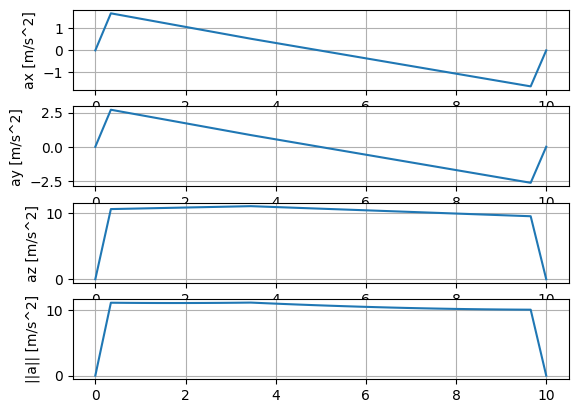

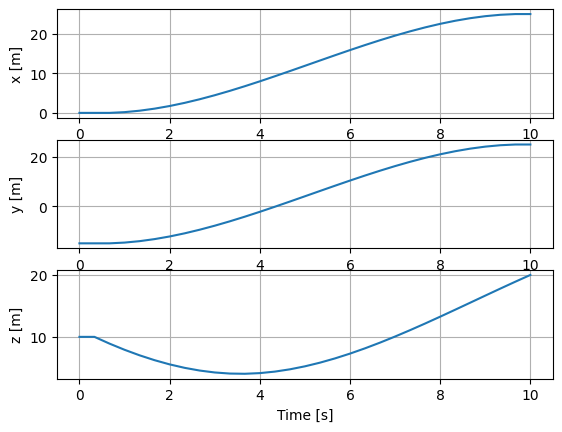

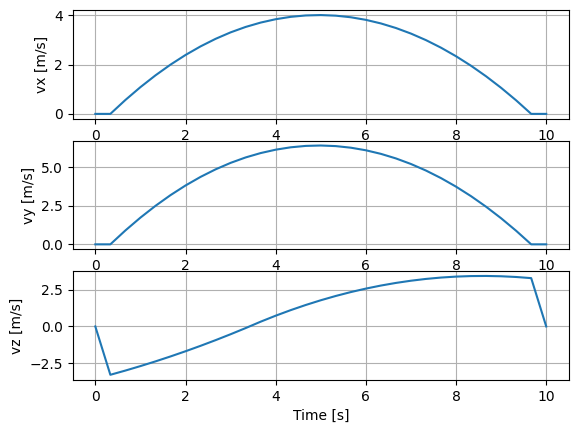

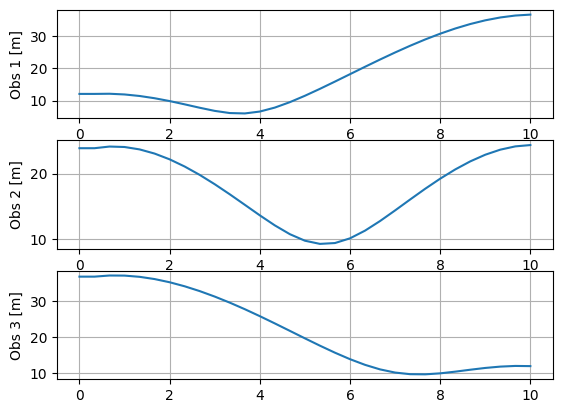

In [7]:
plt.figure(5)
plt.subplot(411)
plt.plot(np.linspace(0, tf, T), a_value[0,:])
plt.ylabel('ax [m/s^2]')
plt.grid(True)
plt.subplot(412)
plt.plot(np.linspace(0, tf, T), a_value[1,:])
plt.ylabel('ay [m/s^2]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(413)
plt.plot(np.linspace(0, tf, T), a_value[2,:])
plt.ylabel('az [m/s^2]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(414)
plt.plot(np.linspace(0, tf, T), np.linalg.norm(a_value,axis=0))
plt.ylabel('||a|| [m/s^2]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)

plt.figure(6)
plt.subplot(311)
plt.plot(np.linspace(0, tf, T+1), nx_value[3,:])
plt.xlabel('Time [s]')
plt.ylabel('x [m]')
plt.grid(True)
plt.subplot(312)
plt.plot(np.linspace(0, tf, T+1), nx_value[4,:])
plt.xlabel('Time [s]')
plt.ylabel('y [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(313)
plt.plot(np.linspace(0, tf, T+1), nx_value[5,:])
plt.xlabel('Time [s]')
plt.ylabel('z [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)

nx_value=nx.value
plt.figure(7)
plt.subplot(311)
plt.plot(np.linspace(0, tf, T+1), nx_value[0,:])
plt.xlabel('Time [s]')
plt.ylabel('vx [m/s]')
plt.grid(True)
plt.subplot(312)
plt.plot(np.linspace(0, tf, T+1), nx_value[1,:])
plt.xlabel('Time [s]')
plt.ylabel('vy [m/s]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(313)
plt.plot(np.linspace(0, tf, T+1), nx_value[2,:])
plt.xlabel('Time [s]')
plt.ylabel('vz [m/s]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)

plt.figure(8)
plt.subplot(311)
pos_dron= nx_value[3:6,:]
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(pos_dron-c_obs1_double,axis=0))
plt.ylabel('Obs 1 [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(312)
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(pos_dron-c_obs2_double,axis=0))
plt.ylabel('Obs 2 [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(313)
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(pos_dron-c_obs3_double,axis=0))
plt.ylabel('Obs 3 [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)

plt.show()

In [1]:
import numpy as np
import plotly.graph_objs as go

def plot_3d_trajectory_with_spheres_and_drone(nx_value, spheres):

    # Extracting trajectory data
    x_traj = nx_value[3,:]
    y_traj = nx_value[4,:]
    z_traj = nx_value[5,:]

    # Plotting the trajectory
    trace_trajectory = go.Scatter3d(
        x=x_traj,
        y=y_traj,
        z=z_traj,
        mode='lines+markers',
        marker=dict(size=5, color='blue'),
        line=dict(color='blue', width=2)
    )
    data = [trace_trajectory]

    # Plotting the drone (initial position)
    trace_drone = go.Scatter3d(
        x=[x_traj[0]],
        y=[y_traj[0]],
        z=[z_traj[0]],
        mode='markers',
        marker=dict(size=10, color='green'),
        name='Drone'
    )
    data.append(trace_drone)

    # Loop to plot each sphere (obstacles)
    for sphere in spheres:
        h = sphere['h']
        rc = sphere['rc']

        # Generating sphere geometry
        u = np.linspace(0, 2 * np.pi, 32)
        v = np.linspace(0, np.pi, 16)
        x_sphere = rc * np.outer(np.cos(u), np.sin(v)) + h[0]
        y_sphere = rc * np.outer(np.sin(u), np.sin(v)) + h[1]
        z_sphere = rc * np.outer(np.ones(np.size(u)), np.cos(v)) + h[2]

        trace_sphere = go.Mesh3d(
            x=x_sphere.ravel(),
            y=y_sphere.ravel(),
            z=z_sphere.ravel(),
            color='red',
            opacity=0.3,
            alphahull=0,
            lighting=dict(ambient=0.5, specular=1.0)
        )

        data.append(trace_sphere)

    # Define the layout
    layout = go.Layout(
        title='Guidance via PTR',
        scene=dict(
            xaxis_title='x [m]',
            yaxis_title='y [m]',
            zaxis_title='z [m]'
        ),
        updatemenus=[dict(type='buttons', showactive=False, buttons=[dict(label='Play',
                          method='animate', args=[None, dict(frame=dict(duration=25, redraw=True), fromcurrent=True, mode='immediate')])])]
    )

    fig = go.Figure(data=data, layout=layout)
    frames = [go.Frame(data=[go.Scatter3d(x=[x_traj[k]], y=[y_traj[k]], z=[z_traj[k]], mode='markers', marker=dict(size=10, color='green'))]) for k in range(len(x_traj))]
    fig.frames = frames
    fig.update_layout(scene=dict(aspectmode='data'))
    fig.show()

spheres = [
    {'h': c_obs1_double, 'rc': d_obs1_double},
    {'h': c_obs2_double, 'rc': d_obs2_double},
    {'h': c_obs3_double, 'rc': d_obs3_double}
]

plot_3d_trajectory_with_spheres_and_drone(nx_value, spheres)

NameError: name 'c_obs1_double' is not defined

# SCVx (math)

Original non-convex optimization problem:

\begin{align*}
    \text{min} \quad &C=\int_{0}^{t_f}||\textbf{a}(t)||_2^2dt\\
    \text{s.t.}\quad
    &\ddot{\textbf{r}}(t)=\textbf{a}(t)-g\begin{bmatrix}
        0\\
        0\\
        1
    \end{bmatrix}\\
    &||\textbf{a}(t)||_2\leq\textbf{a}_\text{max}\\
    &\textbf{r}(0)=\textbf{r}_\text{init},\quad\dot{\textbf{r}}(0)=\textbf{v}_\text{init}\\
    &\textbf{r}(t_f)=\textbf{r}_\text{final},\quad\dot{\textbf{r}}(t_f)=\textbf{v}_\text{final}\\
    &-||\textbf{r}(t)-\textbf{c}_j||_2+d_{obs}\leq 0,\quad j=1,\dots,n_\text{obs}
\end{align*}

Non-convex mathematical model (in particular, it is convex):

\begin{equation}
    \textbf{x}_{k+1}=\textbf{f}(\textbf{x}_k,\textbf{a}_k)=\textbf{A}_d\textbf{x}_k+\textbf{B}_d\textbf{a}_k-\textbf{g}_{\text{aux}}
\end{equation}

SCVx's penalty costs:

\begin{equation}
\small
L(\textbf{d},\textbf{w}):=C(\textbf{x},\textbf{a})+\tau\sum_{k=0}^{T}λ_kP({\textbf{v}}^c,{\textbf{v}}^b)=\tau\sum_{k=0}^{T-1}\cdot ||\textbf{a}_k||^2+\lambda\tau\sum_{k=0}^{T-1}\Bigg( \|{\textbf{v}}_k^c\|_1\Bigg)+\lambda\tau\sum_{k=0}^{T}\sum_{j=1}^{3}\Bigg( ||v_{j/k}^b||_1\Bigg)
\end{equation}

\begin{equation}
\small
J(\textbf{x},\textbf{a}):=C(\textbf{x},\textbf{a})+\sum_{k=0}^{T}λ_kP(\textbf{x}_{k+1}-\textbf{f}({\textbf{x}}_{k},\textbf{a}_k),g(\textbf{r}_k))=\tau\sum_{k=0}^{T-1}||\textbf{a}_k||^2+\lambda\tau\sum_{k=0}^{T-1}\Bigg(\|{\textbf{x}}_{k+1}-\textbf{f}({\textbf{x}}_{k},\textbf{a}_k)\|_1\Bigg)+\lambda\tau\sum_{k=0}^{T}\sum_{j=1}^{3}\Bigg(|| (-\lVert \textbf{r}_k-\textbf{c}_j \rVert+d_{j})||_1\Bigg)
\end{equation}

Actual change in the penalty cost:

\begin{equation}
\Delta J^i:=J(\bar{\textbf{x}},\bar{\textbf{a}})-J(\textbf{x}^*,\textbf{a}^*)
\end{equation}

Predicted change by the convex cost:

\begin{equation}
\Delta L^i:=J(\bar{\textbf{x}},\bar{\textbf{a}})-L(\textbf{d}^*,\textbf{w}^*)
\end{equation}

**SCVx optimization problem**

$$
\begin{aligned}
\min_{\mathbf{d},\mathbf{w}} \quad & L(\mathbf{d},\mathbf{w}) \\[6pt]
\text{s.t.}\quad
& \mathbf{x}_{k+1}
= \mathbf{A}_d\mathbf{x}_k
+ \mathbf{B}_d\mathbf{a}_k
- \mathbf{g}_{aux}
+ \mathbf{v}_k^c \\[6pt]

& \|\mathbf{a}_k\|_2 \le a_{max} \\[6pt]

& \mathbf{r}_0=\mathbf{r}_{init},\quad
  \mathbf{v}_0=\mathbf{v}_{init} \\[6pt]

& \mathbf{r}_{T+1}=\mathbf{r}_{final},\quad
  \mathbf{v}_{T+1}=\mathbf{v}_{final} \\[6pt]

& -\lVert\bar{\mathbf{r}}_k-\mathbf{c}_j\rVert
-\frac{(\bar{\mathbf{r}}_k-\mathbf{c}_j)^T}
{\lVert\bar{\mathbf{r}}_k-\mathbf{c}_j\rVert}
(\mathbf{r}_k-\bar{\mathbf{r}}_k)
+d_j \le v_{k,j}^{b} \\[6pt]

& \|\mathbf{x}-\bar{\mathbf{x}}\|
+ \|\mathbf{a}-\bar{\mathbf{a}}\|
\le r_i
\end{aligned}
$$


Check this paper to look the full algorithm: https://arxiv.org/abs/1804.06539

# SCVx example

In [9]:
!pip install ecos

In [10]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time

print("numpy version",np.__version__)
print("cvxpy version",cp.__version__)

T = 51-1 # 101-1 (101 discretization points)
tf = 10.5
tau = tf/(T)

numpy version 2.2.6
cvxpy version 1.7.3


In [15]:
nx = cp.Variable((6, T + 1), name='new_x')
a = cp.Variable((3, T), name='a')
vc = cp.Variable((6, T), name='vc')
vb1 = cp.Variable((T + 1, 1), name='vb1')
vb2 = cp.Variable((T + 1, 1), name='vb2')
vb3 = cp.Variable((T + 1, 1), name='vb3')

startpos_cvxpy = cp.Parameter((6,1), name='start_pos')
endpos_cvxpy = cp.Parameter((6,1), name='end_pos')

ox_aux = cp.Parameter((6,T + 1), name='ox_aux')
ox_cvxpy = cp.Parameter((6,T + 1), name='ox_cvxpy')
oa_cvxpy = cp.Parameter((3,T), name='oa_cvxpy')

c_obs1 = cp.Parameter((3,1), name='c_obs1')
c_obs2 = cp.Parameter((3,1), name='c_obs2')
c_obs3 = cp.Parameter((3,1), name='c_obs3')

A_discrete = cp.Parameter((6,6), name='A_discrete')
B_discrete = cp.Parameter((6,3), name='B_discrete')

w_vc = cp.Parameter(name='w_vc')
w_vb = cp.Parameter(name='w_vb')
lamb = cp.Parameter(name='lamb')
etta = cp.Parameter(name='etta')

d_obs1 = cp.Parameter(name='d_obs1')
d_obs2 = cp.Parameter(name='d_obs2')
d_obs3 = cp.Parameter(name='d_obs3')

a_max = cp.Parameter(name='a_max')
aux_g = cp.Parameter((6,1), name='aux_g')

constraints = [
    nx[:, 0] == startpos_cvxpy[:,0],
    nx[:, T] == endpos_cvxpy[:,0],
    a[:, 0] == 0, a[:, T-1] == 0
]
cost = 0

for k in range(0, T): # from 0 to T-1
    constraints  += [nx[:, k+1] == A_discrete @ nx[:, k] + B_discrete @ (a[:, k])-tau*aux_g[:,0]+vc[:, k]]
    constraints  += [cp.norm(a[:, k], 2) <= a_max]
    cost += tau*cp.sum_squares(a[:,k])
    cost += tau*cp.norm(lamb*vc[:, k], 1)
    constraints  += [cp.norm(nx[:, k]-ox_cvxpy[:,k],'inf')+cp.norm(a[:, k]-oa_cvxpy[:,k],'inf')<=etta]

#constraints  += [a[:, 7:18]==0] #uncomment if you would like to see a parabolic kinematics
#constraints  += [a[:, 27:T-1]==0] #uncomment if you would like to see a parabolic kinematics
for k in range(0, T+1):
    cost += tau*cp.norm(lamb*vb1[k,0], 1)
    cost += tau*cp.norm(lamb*vb2[k,0], 1)
    cost += tau*cp.norm(lamb*vb3[k,0], 1)

    taylor_f_1 =-cp.norm(ox_cvxpy[3:6,k]-c_obs1[:,0],2)
    taylor_grad_1 = -(ox_cvxpy[3:6,k]-c_obs1[:,0])/(cp.norm(ox_cvxpy[3:6,k]-c_obs1[:,0],2))

    taylor_f_2 =-cp.norm(ox_cvxpy[3:6,k]-c_obs2[:,0],2)
    taylor_grad_2 = -(ox_cvxpy[3:6,k]-c_obs2[:,0])/(cp.norm(ox_cvxpy[3:6,k]-c_obs2[:,0],2))

    taylor_f_3 =-cp.norm(ox_cvxpy[3:6,k]-c_obs3[:,0],2)
    taylor_grad_3 = -(ox_cvxpy[3:6,k]-c_obs3[:,0])/(cp.norm(ox_cvxpy[3:6,k]-c_obs3[:,0],2))

    constraints  += [taylor_f_1+taylor_grad_1.T@(nx[3:6, k]-ox_cvxpy[3:6,k])+d_obs1<=vb1[k,0]]
    constraints  += [taylor_f_2+taylor_grad_2.T@(nx[3:6, k]-ox_cvxpy[3:6,k])+d_obs2<=vb2[k,0]]
    constraints  += [taylor_f_3+taylor_grad_3.T@(nx[3:6, k]-ox_cvxpy[3:6,k])+d_obs3<=vb3[k,0]]

objective = cp.Minimize(cost)
problem = cp.Problem(objective, constraints)

In [16]:
startpos=np.array([[0.0],[0.0],[0.0],[0],[-15],[10.0]])
endpos=np.array([[0.0],[0.0],[0.0],[25],[25],[20.0]]) #descoméntame 1

alpha1=1/4
alpha2=2/4
alpha3=3/4
c_obs1_double = np.array([[alpha1*25+(1-alpha1)*0+0.3],[alpha1*25+(1-alpha1)*(-15)+0.1],[10]])
c_obs2_double = np.array([[alpha2*25+(1-alpha2)*0-0.3],[alpha2*25+(1-alpha2)*(-15)-0.1],[15]]) #descoméntame 1
c_obs3_double = np.array([[alpha3*25+(1-alpha3)*0+0.2],[alpha3*25+(1-alpha3)*(-15)-0.2],[20]]) #descoméntame 1

print("c1:", c_obs1_double)
print("c2:",c_obs2_double)
print("c3:",c_obs3_double)

d_obs1_double = 6
d_obs2_double = 3
d_obs3_double = 6

w_tr_double=0.5
w_vc_double=1000
w_vb_double=5

a_max_double = 25
g_double=9.81

ox_pos = np.column_stack((np.array([np.linspace(startpos[3,0], endpos[3,0], T+1), np.linspace(startpos[4,0], endpos[4,0], T+1),np.linspace(startpos[5,0], endpos[5,0], T+1)]))).T
ox_vel = np.zeros(np.shape(ox_pos))

for t in range(1, T + 1):
    ox_vel[:, t] = (ox_pos[:, t] - ox_pos[:, t - 1])/tau
ox=np.block([[ox_vel],[ox_pos]])
oa=np.zeros((3,T))
A = np.array([[0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [1, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0]])
B = np.vstack((np.eye(3), np.zeros((3, 3))))

A_discrete.value = np.eye(6)+tau*A
B_discrete.value = tau*B
aux_g.value = np.array([[0],[0],[9.81],[0],[0],[0]])
a_max.value = a_max_double

c1: [[ 6.55]
 [-4.9 ]
 [10.  ]]
c2: [[12.2]
 [ 4.9]
 [15. ]]
c3: [[18.95]
 [14.8 ]
 [20.  ]]


In [17]:
def f_SCVx(xk,ak):
    xk = np.reshape(xk, (-1, 1))  # Convert to column vector if needed
    ak = np.reshape(ak, (-1, 1))  # Convert to column vector if needed

    A_discrete_SCVx=np.eye(6)+tau*A
    B_discrete_SCVx=tau*B

    aux_g_value=np.array([[0],[0],[9.81],[0],[0],[0]])
    return A_discrete_SCVx @ xk[:,0:1] + B_discrete_SCVx @ ak[:,0:1] - tau*aux_g_value

def J_SCVx(x,a,T):
    cost = 0
    for k in range(0, T): # from 0 to T-1
        cost += tau*np.linalg.norm(a[:,k], ord=2)**2
        cost += tau*np.linalg.norm(lamb_double*(x[:, k+1:k+2]-f_SCVx(x[:, k:k+1],a[:, k:k+1])), ord=1)

    for k in range(0, T+1):
        cost += tau*np.abs(lamb_double*(np.max([-np.linalg.norm(x[3:6,k:k+1]-c_obs1_double)+d_obs1_double,0])))
        cost += tau*np.abs(lamb_double*(np.max([-np.linalg.norm(x[3:6,k:k+1]-c_obs2_double)+d_obs2_double,0])))
        cost += tau*np.abs(lamb_double*(np.max([-np.linalg.norm(x[3:6,k:k+1]-c_obs3_double)+d_obs3_double,0])))
    return cost
def L_SCVx(x,a,vc,vb1,vb2,vb3,T):
    cost = 0
    for k in range(0, T): # from 0 to T-1
        cost += tau*np.linalg.norm(a[:,k], ord=2)**2
        cost += tau*np.linalg.norm(lamb_double*(vc[:, k]), ord=1)

    for k in range(0, T+1):
        cost += tau*np.abs(lamb_double*(vb1[k,0]))
        cost += tau*np.abs(lamb_double*(vb2[k,0]))
        cost += tau*np.abs(lamb_double*(vb3[k,0]))
    return cost
startpos_cvxpy.value=startpos
endpos_cvxpy.value=endpos

w_vc.value = w_vc_double
w_vb.value = w_vb_double

t0 = time.time()
Kmax_SCP=5

rho0=0.0
rho1=0.1
rho2=0.7
etta0=0.001
etta1=10
beta_sh=2
beta_gr=2

lamb_double=300
etta_double=10

d_obs1.value = d_obs1_double
d_obs2.value = d_obs2_double
d_obs3.value = d_obs3_double

c_obs1.value = c_obs1_double
c_obs2.value = c_obs2_double
c_obs3.value = c_obs3_double

lamb.value = lamb_double
etta.value = etta_double

ox_cvxpy.value=ox #trajectory initialization
oa_cvxpy.value=oa #trajectory initialization
print(J_SCVx(ox,oa,T))
Delta_J_SCVx=100

e_tol=0.005

i=1
while np.abs(Delta_J_SCVx)>e_tol:
#for aux_count in range(1,2):
    val=problem.solve(solver='SCS')

    vc_opt=vc.value
    vb1_opt=vb1.value
    vb2_opt=vb2.value
    vb3_opt=vb3.value
    x_opt=nx.value
    a_opt=a.value

    print("L_cvx: ",val," oJ_SCVx: ",J_SCVx(ox_cvxpy.value,oa_cvxpy.value,T)," J_SCVx: ",J_SCVx(x_opt,a_opt,T)," L_SCVx: ",L_SCVx(x_opt,a_opt,vc_opt,vb1_opt,vb2_opt,vb3_opt,T))
    Delta_J_SCVx=J_SCVx(ox_cvxpy.value,oa_cvxpy.value,T)-J_SCVx(x_opt,a_opt,T)
    Delta_L_SCVx=J_SCVx(ox_cvxpy.value,oa_cvxpy.value,T)-L_SCVx(x_opt,a_opt,vc_opt,vb1_opt,vb2_opt,vb3_opt,T)
    #Delta_L_SCVx=J_SCVx(ox_cvxpy.value,oa_cvxpy.value,T)-val
    #print("Delta_L: ",Delta_L_SCVx)

    if np.abs(Delta_J_SCVx)<e_tol:
      x_global=ox_cvxpy.value
      a_global=oa_cvxpy.value
      break;
    else:
      rho_i=Delta_J_SCVx/Delta_L_SCVx
    if rho_i<rho0:
      etta.value=max([etta0,etta.value/beta_sh])
    if rho_i>=rho0 and rho_i<rho1:
      etta.value=max([etta0,etta.value/beta_sh])
      ox_cvxpy.value=x_opt
      oa_cvxpy.value=a_opt
    if rho_i>=rho1 and rho_i<rho2:
      ox_cvxpy.value=x_opt
      oa_cvxpy.value=a_opt
    if rho_i>=rho2:
      etta.value=min([etta1,beta_gr*etta.value])
      ox_cvxpy.value=x_opt.astype(np.double)
      oa_cvxpy.value=a_opt
    print(" Iteration number: ",i," Cost function: ", val," Etta: ",etta.value, " Rho: ",rho_i)
    i=i+1
t1 = time.time()
print('\nCVXPY\nSolve time: %.3f ms' % (1000 * (t1 - t0)))

10658.65796389118
L_cvx:  2482.6215042438403  oJ_SCVx:  10658.65796389118  J_SCVx:  2365.7790383927772  L_SCVx:  2482.6215042438403
 Iteration number:  1  Cost function:  2482.6215042438403  Etta:  10  Rho:  1.014290844522005
L_cvx:  1150.0289816361567  oJ_SCVx:  2365.7790383927772  J_SCVx:  1150.0294161358431  L_SCVx:  1150.0289816361567
 Iteration number:  2  Cost function:  1150.0289816361567  Etta:  10  Rho:  0.9999996426077186
L_cvx:  1106.8013528059441  oJ_SCVx:  1150.0294161358431  J_SCVx:  1106.8013650802282  L_SCVx:  1106.8013528059441
 Iteration number:  3  Cost function:  1106.8013528059441  Etta:  10  Rho:  0.9999997160575081
L_cvx:  1099.986508338693  oJ_SCVx:  1106.8013650802282  J_SCVx:  1099.9865119849878  L_SCVx:  1099.986508338693
 Iteration number:  4  Cost function:  1099.986508338693  Etta:  10  Rho:  0.9999994649491677
L_cvx:  1095.0854463580936  oJ_SCVx:  1099.9865119849878  J_SCVx:  1095.085740983496  L_SCVx:  1095.0854463580936
 Iteration number:  5  Cost funct

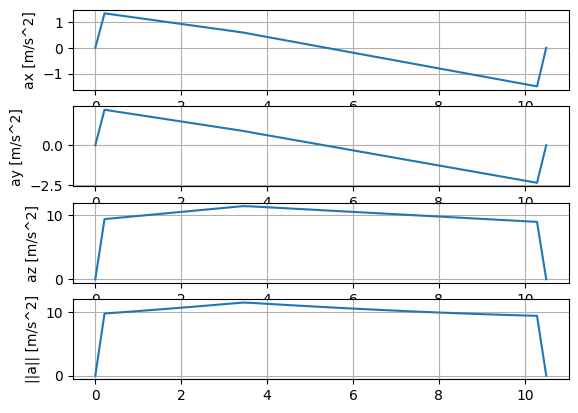

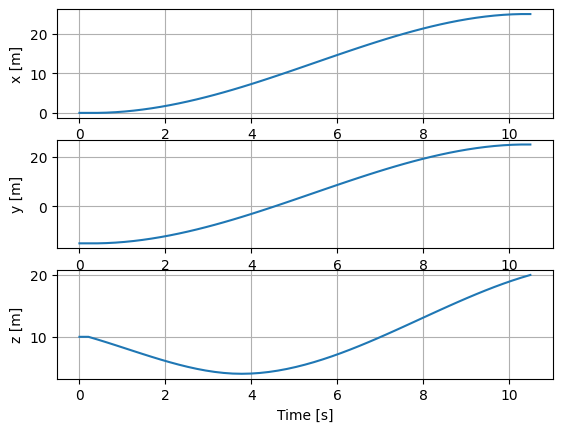

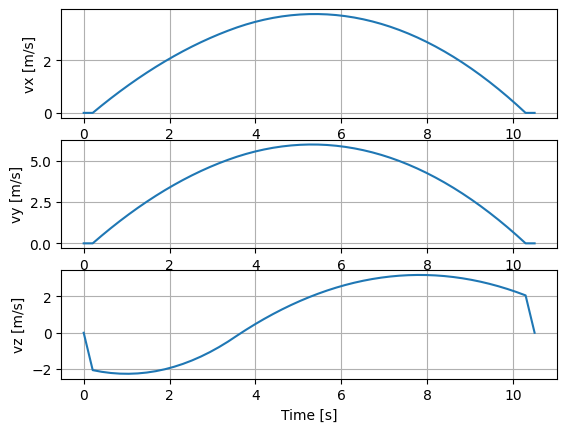

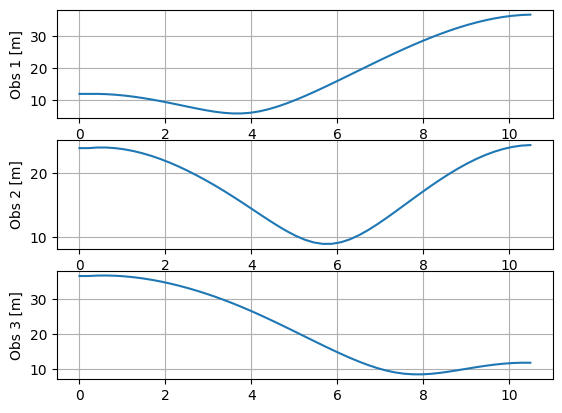

In [18]:
a_value=oa_cvxpy.value
nx_value=ox_cvxpy.value

plt.figure(5)
plt.subplot(411)
plt.plot(np.linspace(0, tf, T), a_value[0,:])
plt.ylabel('ax [m/s^2]')
plt.grid(True)
plt.subplot(412)
plt.plot(np.linspace(0, tf, T), a_value[1,:])
plt.ylabel('ay [m/s^2]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(413)
plt.plot(np.linspace(0, tf, T), a_value[2,:])
plt.ylabel('az [m/s^2]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(414)
plt.plot(np.linspace(0, tf, T), np.linalg.norm(a_value,axis=0))
plt.ylabel('||a|| [m/s^2]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)

plt.figure(6)
plt.subplot(311)
plt.plot(np.linspace(0, tf, T+1), nx_value[3,:])
plt.xlabel('Time [s]')
plt.ylabel('x [m]')
plt.grid(True)
plt.subplot(312)
plt.plot(np.linspace(0, tf, T+1), nx_value[4,:])
plt.xlabel('Time [s]')
plt.ylabel('y [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(313)
plt.plot(np.linspace(0, tf, T+1), nx_value[5,:])
plt.xlabel('Time [s]')
plt.ylabel('z [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)

plt.figure(7)
plt.subplot(311)
plt.plot(np.linspace(0, tf, T+1), nx_value[0,:])
plt.xlabel('Time [s]')
plt.ylabel('vx [m/s]')
plt.grid(True)
plt.subplot(312)
plt.plot(np.linspace(0, tf, T+1), nx_value[1,:])
plt.xlabel('Time [s]')
plt.ylabel('vy [m/s]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(313)
plt.plot(np.linspace(0, tf, T+1), nx_value[2,:])
plt.xlabel('Time [s]')
plt.ylabel('vz [m/s]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)

plt.figure(8)
plt.subplot(311)
pos_dron= nx_value[3:6,:]
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(pos_dron-c_obs1_double,axis=0))
plt.ylabel('Obs 1 [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(312)
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(pos_dron-c_obs2_double,axis=0))
plt.ylabel('Obs 2 [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(313)
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(pos_dron-c_obs3_double,axis=0))
plt.ylabel('Obs 3 [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)

plt.show()

In [19]:
import numpy as np
import plotly.graph_objs as go

def plot_3d_trajectory_with_spheres_and_drone(nx_value, spheres):

    # Extracting trajectory data
    x_traj = nx_value[3,:]
    y_traj = nx_value[4,:]
    z_traj = nx_value[5,:]

    # Plotting the trajectory
    trace_trajectory = go.Scatter3d(
        x=x_traj,
        y=y_traj,
        z=z_traj,
        mode='lines+markers',
        marker=dict(size=5, color='blue'),
        line=dict(color='blue', width=2)
    )
    data = [trace_trajectory]

    # Plotting the drone (initial position)
    trace_drone = go.Scatter3d(
        x=[x_traj[0]],
        y=[y_traj[0]],
        z=[z_traj[0]],
        mode='markers',
        marker=dict(size=10, color='green'),
        name='Drone'
    )
    data.append(trace_drone)

    # Loop to plot each sphere (obstacles)
    for sphere in spheres:
        h = sphere['h']
        rc = sphere['rc']

        # Generating sphere geometry
        u = np.linspace(0, 2 * np.pi, 32)
        v = np.linspace(0, np.pi, 16)
        x_sphere = rc * np.outer(np.cos(u), np.sin(v)) + h[0]
        y_sphere = rc * np.outer(np.sin(u), np.sin(v)) + h[1]
        z_sphere = rc * np.outer(np.ones(np.size(u)), np.cos(v)) + h[2]

        trace_sphere = go.Mesh3d(
            x=x_sphere.ravel(),
            y=y_sphere.ravel(),
            z=z_sphere.ravel(),
            color='red',
            opacity=0.3,
            alphahull=0,
            lighting=dict(ambient=0.5, specular=1.0)
        )

        data.append(trace_sphere)

    # Define the layout
    layout = go.Layout(
        title='Guidance via SCVx',
        scene=dict(
            xaxis_title='x [m]',
            yaxis_title='y [m]',
            zaxis_title='z [m]'
        ),
        updatemenus=[dict(type='buttons', showactive=False, buttons=[dict(label='Play',
                          method='animate', args=[None, dict(frame=dict(duration=25, redraw=True), fromcurrent=True, mode='immediate')])])]
    )

    fig = go.Figure(data=data, layout=layout)
    frames = [go.Frame(data=[go.Scatter3d(x=[x_traj[k]], y=[y_traj[k]], z=[z_traj[k]], mode='markers', marker=dict(size=10, color='green'))]) for k in range(len(x_traj))]
    fig.frames = frames
    fig.update_layout(scene=dict(aspectmode='data'))
    fig.show()

spheres = [
    {'h': c_obs1_double, 'rc': d_obs1_double},
    {'h': c_obs2_double, 'rc': d_obs2_double},
    {'h': c_obs3_double, 'rc': d_obs3_double}
]

plot_3d_trajectory_with_spheres_and_drone(nx_value, spheres)

In [ ]:
np.linalg.norm(vc.value)

5.2043089835548415e-08

# GuSTO (math)

Original non-convex optimization problem:

\begin{align*}
    \text{min} \quad &\Gamma=\int_{0}^{t_f}||\textbf{a}(t)||_2^2dt\\
    \text{s.t.}\quad
    &\ddot{\textbf{r}}(t)=\textbf{a}(t)-g\begin{bmatrix}
        0\\
        0\\
        1
    \end{bmatrix}\\
    &||\textbf{a}(t)||_2\leq\textbf{a}_\text{max}\\
    &\textbf{r}(0)=\textbf{r}_\text{init},\quad\dot{\textbf{r}}(0)=\textbf{v}_\text{init}\\
    &\textbf{r}(t_f)=\textbf{r}_\text{final},\quad\dot{\textbf{r}}(t_f)=\textbf{v}_\text{final}\\
    &-||\textbf{r}(t)-\textbf{c}_j||_2+d_{obs}\leq 0,\quad j=1,\dots,n_\text{obs}
\end{align*}

Non-convex mathematical model (in particular, it is convex):

\begin{equation}
    \textbf{x}_{k+1}=\textbf{f}(\textbf{x}_k,\textbf{a}_k)=\textbf{A}_d\textbf{x}_k+\textbf{B}_d\textbf{a}_k+\tau\begin{bmatrix}
0&0&-g&0&0&0
\end{bmatrix}^T
\end{equation}

GuSTO costs:

\begin{equation}
L_{\lambda}^\Gamma(\textbf{x})=g_{tr}(\textbf{x},\textbf{a})+\sum_{n_w}h_\lambda(w_i(\textbf{x}))+||\textbf{a}||_2^2+\sum_{n_s}h_\lambda\bigg(-\lVert\bar{\textbf{r}}-\textbf{c}_j\rVert_2+d_{j}-\frac{\left(\bar{\textbf{r}}-\textbf{c}_j\right)^T }{\lVert\bar{\textbf{r}}-\textbf{c}_j\rVert_2} \cdot\left(\textbf{r}-\bar{\textbf{r}}\right)\bigg)
\end{equation}

\begin{equation}
L_{\lambda,k}^{\Gamma,N}:=L_{\lambda}^\Gamma(\textbf{x}_k,\textbf{a}_k)
\end{equation}

\begin{equation}
\mathcal{L}_\lambda:=\text{trapz}(L_{\lambda}^{\Gamma,N})
\end{equation}

Where:

\begin{equation}
h_λ:=\lambda([z]^+)^2:=\begin{cases}
\lambda\cdot z^2,\quad z\geq0\\
0,\quad z<0
\end{cases}
\end{equation}

\begin{equation}
g_{tr}(\textbf{x})=h_\lambda(||\textbf{x}-\bar{\textbf{x}}||_\infty-η)
\end{equation}

\begin{equation}
w_i(\textbf{x})\leq 0\quad \forall i\in\{1,\dots,n_w\}\iff \textbf{x}\in\mathcal{X} \quad \text{(Convex inequalities constraints)}
\end{equation}

To update $\eta$ and $\lambda$:

\begin{equation}
\dot{\textbf{x}}_k^*:=\textbf{A}_d\textbf{x}_k^*+\textbf{B}_d\textbf{a}_k^*+\tau\begin{bmatrix}
0&0&-g&0&0&0
\end{bmatrix}^T
\end{equation}

\begin{equation}
\Delta f_k^*:=||\textbf{f}(\textbf{x}_k^*,\textbf{a}_k^*)-\dot{\textbf{x}}_k^*||_2=||\textbf{A}_d\textbf{x}_k+\textbf{B}_d\textbf{a}_k+τ\begin{bmatrix}
0&0&-g&0&0&0
\end{bmatrix}-\dot{\textbf{x}}_k^*||_2=0
\end{equation}

\begin{equation}
\Theta^*:=\text{trapz}(\Delta f^*)=0
\end{equation}

\begin{equation}
\times^*_k:=||\dot{\textbf{x}}_k^*||_2
\end{equation}

And:

\begin{equation}
J_\lambda^\Gamma(\textbf{x}_k,\textbf{a}_k):=\Gamma(\textbf{x}_k,\textbf{a}_k)+g_{tr}(\textbf{x}_k)+\sum_{n_w}h_\lambda(w_i(\textbf{x}_k))+\sum_{n_s}h_\lambda(s_i(\textbf{x}_k))
\end{equation}

\begin{equation}
J_\lambda^\Gamma(\textbf{x}_k,\textbf{a}_k)=||\textbf{a}_k||_2^2+h_\lambda(||\textbf{x}_k-\bar{\textbf{x}}||_\infty-η)+0+\sum_{n_s}h_\lambda(-||\textbf{r}_k-\textbf{c}_j||_2+d_{obs})
\end{equation}

\begin{equation}
J_{\lambda,k}^{\Gamma,N}:=J_\lambda^\Gamma(\textbf{x}_k,\textbf{a}_k)
\end{equation}

\begin{equation}
\mathcal{J}_{\lambda}(\textbf{x},\textbf{u}):=\text{trapz}(J_{\lambda}^{\Gamma,N})
\end{equation}

\begin{equation}
\rho:=\frac{|\mathcal{J}_\lambda(\textbf{x}^*,\textbf{u}^*)-\mathcal{L}_\lambda(\textbf{x}^*,\textbf{u}^*)|+\Theta^*}{|\mathcal{L}_\lambda(\textbf{x}^*,\textbf{u}^*)|+\text{trapz}(\times^*)}
\end{equation}

Additional hint:

\begin{equation}
\text{update}(\lambda)=\begin{cases}
\lambda_0,\quad -\lVert \textbf{r}_k^*-\textbf{c}_j \rVert+d_{j}\leq 0\quad\text{and}\quad\textbf{x}_k^*\in\mathcal{X}\quad\forall k,j\\
\gamma_\text{fail}\lambda,\quad\text{else}
\end{cases}
\end{equation}

In each iteration the following optimization problem is solved:

\begin{align*}
    \text{min} \quad &\mathcal{L}_{\lambda}\\
    \text{s.t.}\quad
    &\textbf{x}_{k+1}=\textbf{A}_d\textbf{x}_k+\textbf{B}_d\textbf{a}_k\\
    &||\textbf{a}_k||_2\leq\textbf{a}_\text{max}\\
    &\textbf{r}_0=\textbf{r}_\text{init},\quad\textbf{v}_0=\textbf{v}_\text{init}\\
    &\textbf{r}_{T+1}=\textbf{r}_\text{final},\quad\textbf{v}_{T+1}=\textbf{v}_\text{final}
\end{align*}

In order to follow both Disciplined Convex Programming (DCP) and Disciplined Parametrized Programming (DPP) rules:

\begin{equation*}
\lambda\cdot\bigg(-\lVert\bar{\textbf{r}}-\textbf{c}_j\rVert_2+d_{j}-\frac{\left(\bar{\textbf{r}}-\textbf{c}_j\right)^T }{\lVert\bar{\textbf{r}}-\textbf{c}_j\rVert_2} \cdot\left(\textbf{r}-\bar{\textbf{r}}\right)\bigg)^2
\end{equation*}


\begin{equation}
=(\textbf{a}_{aux}^T\textbf{r})^2-2\textbf{b}_{aux}\cdot\textbf{r}+\text{c}_{aux}
\end{equation}

Where

$$
\begin{equation}
\mathbf{a}_{aux}=
\sqrt{\lambda}\;
\frac{\bar{\mathbf{r}}-\mathbf{c}_j}
{\|\bar{\mathbf{r}}-\mathbf{c}_j\|_2}
\end{equation}
$$

$$
\begin{equation}
\mathbf{b}_{aux}=
2\lambda
\frac{(\bar{\mathbf{r}}-\mathbf{c}_j)^T}
{\|\bar{\mathbf{r}}-\mathbf{c}_j\|_2}
\bar{\mathbf{r}}
\frac{(\bar{\mathbf{r}}-\mathbf{c}_j)^T}
{\|\bar{\mathbf{r}}-\mathbf{c}_j\|_2}-
2\lambda\left(
\|\bar{\mathbf{r}}-\mathbf{c}_j\|_2 + d_j
\right)
\end{equation}
$$

$$
\begin{equation}
c_{aux}=
\lambda\left(
\frac{(\bar{\mathbf{r}}-\mathbf{c}_j)^T}
{\|\bar{\mathbf{r}}-\mathbf{c}_j\|_2}
\bar{\mathbf{r}}
\right)^2
+
\lambda\left(
-\|\bar{\mathbf{r}}-\mathbf{c}_j\|_2 + d_j
\right)^2
\end{equation}
$$


# GuSTO example

In [20]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time

print("numpy version",np.__version__)
print("cvxpy version",cp.__version__)

T = 31-1 # 101-1 (101 discretization points)
tf = 5.0
tau = tf/(T)

numpy version 2.2.6
cvxpy version 1.7.3


In [21]:
nx = cp.Variable((6, T + 1), name='new_x')
a = cp.Variable((3, T), name='a')
etta = cp.Parameter(name='etta')

startpos_cvxpy = cp.Parameter((6,1), name='start_pos')
endpos_cvxpy = cp.Parameter((6,1), name='end_pos')

ox_aux = cp.Parameter((6,T + 1), name='ox_aux')
etta_ox_aux = cp.Parameter((6,T + 1), name='etta_ox_aux')
ox_cvxpy = cp.Parameter((6,T + 1), name='ox_cvxpy')
oa_cvxpy = cp.Parameter((3,T), name='oa_cvxpy')

c_obs1 = cp.Parameter((3,1), name='c_obs1')
c_obs2 = cp.Parameter((3,1), name='c_obs2')
c_obs3 = cp.Parameter((3,1), name='c_obs3')

aux_a_obs1 = cp.Parameter((T+1,1), name='aux_a_obs1')
aux_b_obs1 = cp.Parameter((T+1,3), name='aux_b_obs2')

aux_a_obs2 = cp.Parameter((T+1,1), name='aux_a_obs2')
aux_b_obs2 = cp.Parameter((T+1,3), name='aux_b_obs2')

aux_a_obs3 = cp.Parameter((T+1,1), name='aux_a_obs3')
aux_b_obs3 = cp.Parameter((T+1,3), name='aux_b_obs3')

aux_aux_a_obs1 = np.zeros((T+1,1))
aux_aux_b_obs1 = np.zeros((T+1,3))

aux_aux_a_obs2 = np.zeros((T+1,1))
aux_aux_b_obs2 = np.zeros((T+1,3))

aux_aux_a_obs3 = np.zeros((T+1,1))
aux_aux_b_obs3 = np.zeros((T+1,3))

A_discrete = cp.Parameter((6,6), name='A_discrete')
B_discrete = cp.Parameter((6,3), name='B_discrete')

lamb = cp.Parameter(name='lamb')
sqrt_lamb = cp.Parameter(name='sqrt_lamb')
sqrtlamb_etta = cp.Parameter(name='sqrtlamb_etta')

d_obs1 = cp.Parameter(name='d_obs1')
d_obs2 = cp.Parameter(name='d_obs2')
d_obs3 = cp.Parameter(name='d_obs3')

a_max = cp.Parameter(name='a_max')
aux_g = cp.Parameter((6,1), name='aux_g')

constraints = [
    nx[:, 0] == startpos_cvxpy[:,0],
    nx[:, T] == endpos_cvxpy[:,0],
    a[:, 0] == 0, a[:, T-1] == 0
]
cost = 0

for k in range(0, T): # from 0 to T-1
    constraints  += [nx[:, k+1] == A_discrete @ nx[:, k] + B_discrete @ (a[:, k])-tau*aux_g[:,0]]
    constraints  += [cp.norm(a[:, k], 2)<=a_max]
    cost += tau*cp.sum_squares(a[:,k]) #sum(a**2)
    #sum_nw_hlambda(w(x)) = 0

for k in range(0, T+1):
    cost += tau*cp.power(cp.pos(cp.sum([cp.norm(sqrt_lamb*nx[:, k]-ox_aux[:,k],'inf'),-sqrtlamb_etta])),2) #g_tr

    cost += tau*cp.power(cp.pos(cp.sum([aux_a_obs1[k,0],aux_b_obs1[k,:]@nx[3:6, k]])),2) #sum_n_s
    cost += tau*cp.power(cp.pos(cp.sum([aux_a_obs2[k,0],aux_b_obs2[k,:]@nx[3:6, k]])),2) #sum_n_s
    cost += tau*cp.power(cp.pos(cp.sum([aux_a_obs3[k,0],aux_b_obs3[k,:]@nx[3:6, k]])),2) #sum_n_s

objective = cp.Minimize(cost)
problem = cp.Problem(objective, constraints)

Let's check if our modeled optimization problems follows Disciplined Parametrized Programming rules.

In [22]:
print("Is DPP? ", problem.is_dcp(dpp=True))

Is DPP?  True


In [23]:
startpos=np.array([[0.0],[0.0],[0.0],[0],[-15],[10.0]])
endpos=np.array([[0.0],[0.0],[0.0],[25],[25],[20.0]]) #descoméntame 1

alpha1=1/4
alpha2=2/4
alpha3=3/4
c_obs1_double = np.array([[alpha1*25+(1-alpha1)*0+0.3],[alpha1*25+(1-alpha1)*(-15)+0.1],[10]])
c_obs2_double = np.array([[alpha2*25+(1-alpha2)*0-0.3],[alpha2*25+(1-alpha2)*(-15)-0.1],[15]]) #descoméntame 1
c_obs3_double = np.array([[alpha3*25+(1-alpha3)*0+0.2],[alpha3*25+(1-alpha3)*(-15)-0.2],[20]]) #descoméntame 1

print("c1:", c_obs1_double)
print("c2:", c_obs2_double)
print("c3:", c_obs3_double)

d_obs1_double = 6
d_obs2_double = 3
d_obs3_double = 6

a_max_double = 25*2
g_double=9.81

obs_tol_double=0.005 #5mm (useful for lambda_update)

ox_pos = np.column_stack((np.array([np.linspace(startpos[3,0], endpos[3,0], T+1), np.linspace(startpos[4,0], endpos[4,0], T+1),np.linspace(startpos[5,0], endpos[5,0], T+1)]))).T
ox_vel = np.zeros(np.shape(ox_pos))

for t in range(1, T + 1):
    ox_vel[:, t] = (ox_pos[:, t] - ox_pos[:, t - 1])/tau
ox=np.block([[ox_vel],[ox_pos]])
oa=np.zeros((3,T))
A = np.array([[0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [1, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0]])
B = np.vstack((np.eye(3), np.zeros((3, 3))))

A_discrete.value = np.eye(6)+tau*A
B_discrete.value = tau*B
aux_g.value = np.array([[0],[0],[9.81],[0],[0],[0]])
a_max.value = a_max_double

c1: [[ 6.55]
 [-4.9 ]
 [10.  ]]
c2: [[12.2]
 [ 4.9]
 [15. ]]
c3: [[18.95]
 [14.8 ]
 [20.  ]]


In [24]:
def h_lambda(z):
  if z>=0:
    return lamb.value*z**2
  if z<0:
    return 0
def lamb_update(lamb,x_opt,T):
    obs1_bool=True
    obs2_bool=True
    obs3_bool=True
    for k in range(0,T+1,1):
        obs1_bool=(np.linalg.norm(x_opt[3:6,k:k+1]-c_obs1_double,ord=2)>=d_obs1_double-obs_tol_double) and obs1_bool
        obs2_bool=(np.linalg.norm(x_opt[3:6,k:k+1]-c_obs2_double,ord=2)>=d_obs2_double-obs_tol_double) and obs2_bool
        obs3_bool=(np.linalg.norm(x_opt[3:6,k:k+1]-c_obs3_double,ord=2)>=d_obs3_double-obs_tol_double) and obs3_bool
        if not(obs1_bool) or not(obs2_bool) or not(obs3_bool):
            print("obs 1",np.linalg.norm(x_opt[3:6,k:k+1]-c_obs1_double,ord=2)-d_obs1_double)
            print("obs 2",np.linalg.norm(x_opt[3:6,k:k+1]-c_obs2_double,ord=2)-d_obs2_double)
            print("obs 3",np.linalg.norm(x_opt[3:6,k:k+1]-c_obs3_double,ord=2)-d_obs3_double)
            break;
    print("obs 1 bool: ",obs1_bool)
    print("obs 2 bool: ",obs2_bool)
    print("obs 3 bool: ",obs3_bool)
    if obs1_bool and obs2_bool and obs3_bool:
        return lambda_0
    else:
        return gamma_fail*lamb
def sum_x_star(x_opt,a_opt,T):
    A_discrete_GuSTO=np.eye(6)+tau*A
    B_discrete_GuSTO=tau*B
    sum_x=0
    #print("dx_k_star")
    for k in range(0,T,1):
        dx_k_star=A_discrete_GuSTO@x_opt[:, k:k+1]+B_discrete_GuSTO@a_opt[:, k:k+1]-tau*np.array([[0],[0],[9.81],[0],[0],[0]])
        #print(dx_k_star)
        sum_x+=tau*np.linalg.norm(dx_k_star,ord=2)
    return sum_x
def J_lamb_GuSTO(x,a,etta,T):
    cost1 = 0
    cost2 = 0
    cost3 = 0
    for k in range(0, T): # from 0 to T-1
        cost1+=tau*np.linalg.norm(a[:,k:k+1], ord=2)**2
    for k in range(0, T+1):
        cost2 += tau*h_lambda(np.linalg.norm(x[:,k:k+1]-ox[:,k:k+1], ord=np.inf)-etta)
    for k in range(0, T+1):
        cost3 += tau*h_lambda(-np.linalg.norm(x[3:6,k:k+1]-c_obs1_double, ord=2)+d_obs1_double)
        cost3 += tau*h_lambda(-np.linalg.norm(x[3:6,k:k+1]-c_obs2_double, ord=2)+d_obs2_double)
        cost3 += tau*h_lambda(-np.linalg.norm(x[3:6,k:k+1]-c_obs3_double, ord=2)+d_obs3_double)
    return cost1+cost2+cost3

startpos_cvxpy.value=startpos
endpos_cvxpy.value=endpos

t0 = time.time()

lambda_0=10**4
lambda_max=10**9
etta_double=10

rho0=0.1
rho1=0.9

etta0=0.001
etta1=10

lamb_double=lambda_0
sqrt_lamb_double=np.sqrt(lambda_0)
etta_double=10

beta_sh=2
beta_gr=2

gamma_fail=5
mu=0.8
k_star=6

d_obs1.value = d_obs1_double
d_obs2.value = d_obs2_double
d_obs3.value = d_obs3_double

c_obs1.value = c_obs1_double
c_obs2.value = c_obs2_double
c_obs3.value = c_obs3_double

lamb.value = lamb_double
sqrt_lamb.value = sqrt_lamb_double
etta.value = etta_double
sqrtlamb_etta.value = sqrt_lamb_double*etta_double

ox_cvxpy.value = ox #trajectory initialization (control)
ox_aux.value = sqrt_lamb_double*ox

oa = np.zeros((3,T)) #trajectory initialization (input)
oa_cvxpy.value = oa #trajectory initialization (input)

e_tol=0.024 #stopping threshold related to Delta_u

i=1
trapz_Deltau=100

J_GuSTO_stop=100
epsilon_r=0.001

while lamb.value<lambda_max and (trapz_Deltau>e_tol) and J_GuSTO_stop>epsilon_r:
    for k in range(0,T+1,1):
        aux_aux_a_obs1[k,0] = -np.sqrt(lamb.value)*np.linalg.norm(ox[3:6,k]-c_obs1.value[:,0],2)+np.sqrt(lamb.value)*d_obs1.value+np.sqrt(lamb.value)*(ox[3:6,k]-c_obs1.value[:,0]).T/(np.linalg.norm(ox[3:6,k]-c_obs1.value[:,0],2))@ox[3:6,k]
        aux_aux_b_obs1[k:k+1,:] = -np.sqrt(lamb.value)*(ox[3:6,k]-c_obs1.value[:,0]).T/(np.linalg.norm(ox[3:6,k]-c_obs1.value[:,0],2))

        aux_aux_a_obs2[k,0] = -np.sqrt(lamb.value)*np.linalg.norm(ox[3:6,k]-c_obs2.value[:,0],2)+np.sqrt(lamb.value)*d_obs2.value+np.sqrt(lamb.value)*(ox[3:6,k]-c_obs2.value[:,0]).T/(np.linalg.norm(ox[3:6,k]-c_obs2.value[:,0],2))@ox[3:6,k]
        aux_aux_b_obs2[k:k+1,:] = -np.sqrt(lamb.value)*(ox[3:6,k]-c_obs2.value[:,0]).T/(np.linalg.norm(ox[3:6,k]-c_obs2.value[:,0],2))

        aux_aux_a_obs3[k,0] = -np.sqrt(lamb.value)*np.linalg.norm(ox[3:6,k]-c_obs3.value[:,0],2)+np.sqrt(lamb.value)*d_obs3.value+np.sqrt(lamb.value)*(ox[3:6,k]-c_obs3.value[:,0]).T/(np.linalg.norm(ox[3:6,k]-c_obs3.value[:,0],2))@ox[3:6,k]
        aux_aux_b_obs3[k:k+1,:] = -np.sqrt(lamb.value)*(ox[3:6,k]-c_obs3.value[:,0]).T/(np.linalg.norm(ox[3:6,k]-c_obs3.value[:,0],2))

    aux_a_obs1.value=aux_aux_a_obs1
    aux_b_obs1.value=aux_aux_b_obs1

    aux_a_obs2.value=aux_aux_a_obs2
    aux_b_obs2.value=aux_aux_b_obs2

    aux_a_obs3.value=aux_aux_a_obs3
    aux_b_obs3.value=aux_aux_b_obs3

    val = problem.solve()

    L_lambda=val
    x_opt = nx.value
    a_opt = a.value

    trapz_Deltau=0
    for k in range(0,T,1):
        trapz_Deltau+=tau*np.linalg.norm(a_opt[:, k:k+1]-oa[:, k:k+1], ord=np.inf)

    J_lamb_opt=J_lamb_GuSTO(x_opt,a_opt,etta.value,T)
    J_lamb_old=J_lamb_GuSTO(ox,oa,etta.value,T)
    J_GuSTO_stop=np.abs(J_lamb_old-J_lamb_opt)/np.abs(J_lamb_old)

    flag_case4=True
    for k in range(0,T+1,1):
        if np.linalg.norm(x_opt[:, k:k+1]-ox[:, k:k+1], ord=np.inf)>etta.value:
            print("Case 4")
            etta.value=etta.value
            ox=ox
            oa=oa
            lamb.value=gamma_fail*lamb.value
            flag_case4=False
            break;
    if flag_case4:
      rho_i=(abs(J_lamb_opt-L_lambda))/(abs(L_lambda)+sum_x_star(x_opt,a_opt,T))
      print("J_lamb_GuSTO: ",J_lamb_GuSTO(x_opt,a_opt,etta.value,T)," L_lambda: ",L_lambda," rho:",rho_i)
      if rho_i<rho0:
          etta.value=min([etta1,beta_gr*etta.value])
          ox = x_opt
          oa = a_opt
          lamb.value=lamb_update(lamb.value,x_opt,T)
          print("Case 1")
      if rho_i>=rho0 and rho_i<rho1:
          etta.value=etta.value
          ox = x_opt
          oa = a_opt
          lamb.value=lamb_update(lamb.value,x_opt,T)
          print("Case 2")
      if rho_i>=rho1:
          etta.value=max([etta0,etta.value/beta_sh])
          ox=ox
          oa=oa
          lamb.value=lamb.value
          print("Case 3")

    sqrtlamb_etta.value = (lamb.value)**0.5*etta.value
    ox_cvxpy.value=ox
    oa_cvxpy.value=oa
    ox_aux.value = (lamb.value)**0.5*ox
    sqrt_lamb.value=(lamb.value)**0.5

    print(" Iteration number: ",i," Cost function: ", val," Etta: ",etta.value,"Lambda: ",lamb.value,"Trap_Du: ",trapz_Deltau, "J_stop: ",J_GuSTO_stop)
    i=i+1

t1 = time.time()
print('\nCVXPY\nSolve time: %.3f ms' % (1000 * (t1 - t0)))

J_lamb_GuSTO:  1632.0186564287144  L_lambda:  1643.2702623927569  rho: 0.006289521853529513
obs 1 bool:  True
obs 2 bool:  True
obs 3 bool:  True
Case 1
 Iteration number:  1  Cost function:  1643.2702623927569  Etta:  10 Lambda:  10000 Trap_Du:  67.81328393371305 J_stop:  0.9889986813824553
J_lamb_GuSTO:  1005.402822228865  L_lambda:  1006.0468915430235  rho: 0.000559266759873259
obs 1 bool:  True
obs 2 bool:  True
obs 3 bool:  True
Case 1
 Iteration number:  2  Cost function:  1006.0468915430235  Etta:  10 Lambda:  10000 Trap_Du:  28.386728929001354 J_stop:  0.38395139156745267
J_lamb_GuSTO:  916.958466419578  L_lambda:  917.2151965046932  rho: 0.0002419171693107377
obs 1 bool:  True
obs 2 bool:  True
obs 3 bool:  True
Case 1
 Iteration number:  3  Cost function:  917.2151965046932  Etta:  10 Lambda:  10000 Trap_Du:  10.531990704358837 J_stop:  0.08796907453792084
J_lamb_GuSTO:  900.9543134369081  L_lambda:  901.0734249682175  rho: 0.0001141051625023601
obs 1 bool:  True
obs 2 bool: 

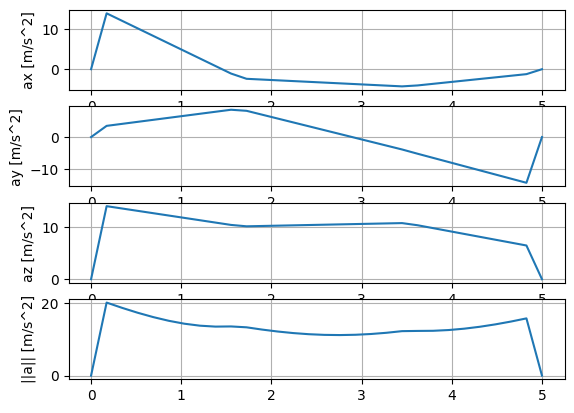

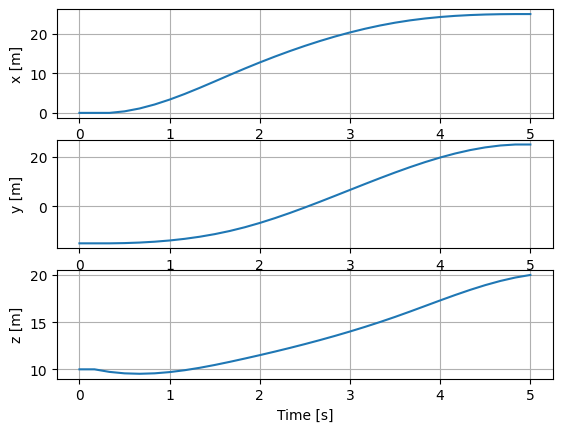

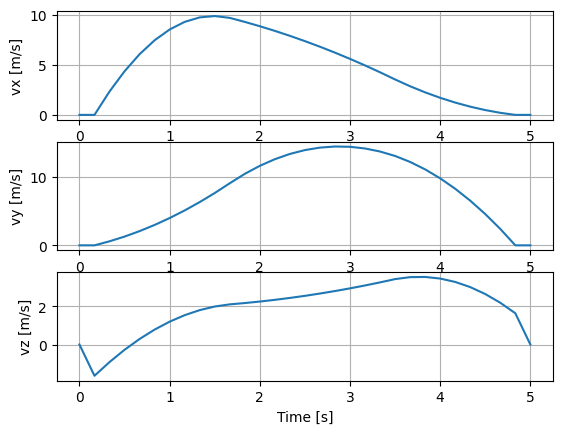

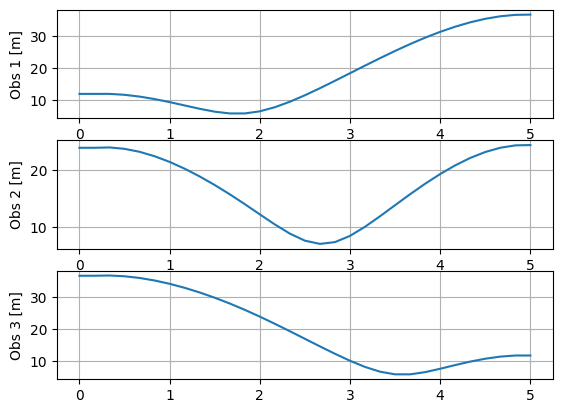

In [25]:
a_value=a.value
nx_value=nx.value

plt.figure(5)
plt.subplot(411)
plt.plot(np.linspace(0, tf, T), a_value[0,:])
plt.ylabel('ax [m/s^2]')
plt.grid(True)
plt.subplot(412)
plt.plot(np.linspace(0, tf, T), a_value[1,:])
plt.ylabel('ay [m/s^2]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(413)
plt.plot(np.linspace(0, tf, T), a_value[2,:])
plt.ylabel('az [m/s^2]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(414)
plt.plot(np.linspace(0, tf, T), np.linalg.norm(a_value,axis=0))
plt.ylabel('||a|| [m/s^2]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)

plt.figure(6)
plt.subplot(311)
plt.plot(np.linspace(0, tf, T+1), nx_value[3,:])
plt.xlabel('Time [s]')
plt.ylabel('x [m]')
plt.grid(True)
plt.subplot(312)
plt.plot(np.linspace(0, tf, T+1), nx_value[4,:])
plt.xlabel('Time [s]')
plt.ylabel('y [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(313)
plt.plot(np.linspace(0, tf, T+1), nx_value[5,:])
plt.xlabel('Time [s]')
plt.ylabel('z [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)

plt.figure(7)
plt.subplot(311)
plt.plot(np.linspace(0, tf, T+1), nx_value[0,:])
plt.xlabel('Time [s]')
plt.ylabel('vx [m/s]')
plt.grid(True)
plt.subplot(312)
plt.plot(np.linspace(0, tf, T+1), nx_value[1,:])
plt.xlabel('Time [s]')
plt.ylabel('vy [m/s]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(313)
plt.plot(np.linspace(0, tf, T+1), nx_value[2,:])
plt.xlabel('Time [s]')
plt.ylabel('vz [m/s]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)

plt.figure(8)
plt.subplot(311)
pos_dron= nx_value[3:6,:]
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(pos_dron-c_obs1_double,axis=0))
plt.ylabel('Obs 1 [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(312)
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(pos_dron-c_obs2_double,axis=0))
plt.ylabel('Obs 2 [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(313)
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(pos_dron-c_obs3_double,axis=0))
plt.ylabel('Obs 3 [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)

plt.show()

In [26]:
import numpy as np
import plotly.graph_objs as go

def plot_3d_trajectory_with_spheres_and_drone(nx_value, spheres):

    # Extracting trajectory data
    x_traj = nx_value[3,:]
    y_traj = nx_value[4,:]
    z_traj = nx_value[5,:]

    # Plotting the trajectory
    trace_trajectory = go.Scatter3d(
        x=x_traj,
        y=y_traj,
        z=z_traj,
        mode='lines+markers',
        marker=dict(size=5, color='blue'),
        line=dict(color='blue', width=2)
    )
    data = [trace_trajectory]

    # Plotting the drone (initial position)
    trace_drone = go.Scatter3d(
        x=[x_traj[0]],
        y=[y_traj[0]],
        z=[z_traj[0]],
        mode='markers',
        marker=dict(size=10, color='green'),
        name='Drone'
    )
    data.append(trace_drone)

    # Loop to plot each sphere (obstacles)
    for sphere in spheres:
        h = sphere['h']
        rc = sphere['rc']

        # Generating sphere geometry
        u = np.linspace(0, 2 * np.pi, 32)
        v = np.linspace(0, np.pi, 16)
        x_sphere = rc * np.outer(np.cos(u), np.sin(v)) + h[0]
        y_sphere = rc * np.outer(np.sin(u), np.sin(v)) + h[1]
        z_sphere = rc * np.outer(np.ones(np.size(u)), np.cos(v)) + h[2]

        trace_sphere = go.Mesh3d(
            x=x_sphere.ravel(),
            y=y_sphere.ravel(),
            z=z_sphere.ravel(),
            color='red',
            opacity=0.3,
            alphahull=0,
            lighting=dict(ambient=0.5, specular=1.0)
        )

        data.append(trace_sphere)

    # Define the layout
    layout = go.Layout(
        title='Guidance via GuSTO',
        scene=dict(
            xaxis_title='x [m]',
            yaxis_title='y [m]',
            zaxis_title='z [m]'
        ),
        updatemenus=[dict(type='buttons', showactive=False, buttons=[dict(label='Play',
                          method='animate', args=[None, dict(frame=dict(duration=25, redraw=True), fromcurrent=True, mode='immediate')])])]
    )

    fig = go.Figure(data=data, layout=layout)
    frames = [go.Frame(data=[go.Scatter3d(x=[x_traj[k]], y=[y_traj[k]], z=[z_traj[k]], mode='markers', marker=dict(size=10, color='green'))]) for k in range(len(x_traj))]
    fig.frames = frames
    fig.update_layout(scene=dict(aspectmode='data'))
    fig.show()

spheres = [
    {'h': c_obs1_double, 'rc': d_obs1_double},
    {'h': c_obs2_double, 'rc': d_obs2_double},
    {'h': c_obs3_double, 'rc': d_obs3_double}
]

plot_3d_trajectory_with_spheres_and_drone(nx_value, spheres)

# SCVx astrobee

Let the general **Linear Time-Varying (LTV) system** be

$$
\begin{equation}
\dot{\mathbf{x}}(t)=\mathbf{A}(t)\mathbf{x}(t)+\mathbf{B}(t)\mathbf{u}(t)+\mathbf{w}(t)
\end{equation}
$$

For a time interval $ t \in [t_k,t_{k+1}] $, the exact solution for $ \mathbf{x}(t) $ is given by

$$
\begin{equation}
\mathbf{x}(t)=\Phi(t,t_k)\mathbf{x}(t_k)
+\int_{t_k}^{t}\Phi(t,\xi)\mathbf{B}(\xi)\mathbf{u}(\xi)\,d\xi
+\int_{t_k}^{t}\Phi(t,\xi)\mathbf{w}(\xi)\,d\xi
\end{equation}
$$

Assume that $\mathbf{A}(t)$ and $\mathbf{B}(t)$ are constant over the interval and that a **zero-order hold (ZOH)** is applied to $ \mathbf{u}(t) $ and $ \mathbf{w}(t) $.  
This implies that $ \mathbf{u}(t_k) $ and $ \mathbf{w}(t_k) $ remain constant on $ [t_k,t_{k+1}] $.  
Therefore, evaluating the solution at $ t_{k+1} $ yields

$$
\begin{equation}
\mathbf{x}(t_{k+1})=
e^{\mathbf{A}(t_{k+1}-t_k)}\mathbf{x}(t_k)
+
\Bigg(\int_{0}^{t_{k+1}-t_k}e^{\mathbf{A}(t_{k+1}-t_k-\xi)}d\xi\Bigg)\mathbf{B}\mathbf{u}(t_k)
+
\Bigg(\int_{0}^{t_{k+1}-t_k}e^{\mathbf{A}(t_{k+1}-t_k-\xi)}d\xi\Bigg)\mathbf{w}(t_k)
\end{equation}
$$

Let $ \tau \triangleq t_{k+1}-t_k $. Expanding the exponential series gives

$$
\begin{equation}
\mathbf{x}(t_{k+1})=
\sum_{k=0}^{\infty}\frac{1}{k!}(\mathbf{A}\tau)^k\mathbf{x}(t_k)
+
\left(\sum_{k=1}^{\infty}\frac{1}{k!}\mathbf{A}^{k-1}\tau^k\right)\mathbf{B}\mathbf{u}(t_k)
+
\left(\sum_{k=1}^{\infty}\frac{1}{k!}\mathbf{A}^{k-1}\tau^k\right)\mathbf{w}(t_k)
\end{equation}
$$

Define

$$
\begin{equation}
\mathbf{x}_{j}\triangleq\mathbf{x}(t_{j}),\quad
\mathbf{A}_d\triangleq\sum_{k=0}^{\infty}\frac{1}{k!}(\mathbf{A}\tau)^k,\quad
\mathbf{B}_d\triangleq\sum_{k=1}^{\infty}\frac{1}{k!}\mathbf{A}^{k-1}\tau^k\mathbf{B},\quad
\mathbf{w}_d\triangleq\sum_{k=1}^{\infty}\frac{1}{k!}\mathbf{A}^{k-1}\tau^k\mathbf{w}
\end{equation}
$$

Therefore, the exact discretized model is

$$
\begin{equation}
\mathbf{x}_{k+1}=\mathbf{A}_d\mathbf{x}_k+\mathbf{B}_d\mathbf{u}_k+\mathbf{w}_d
\end{equation}
$$

**Note:** In practice, many engineers approximate the series by keeping only the first terms

$$
\begin{equation}
\mathbf{A}_d\approx(I+\tau\mathbf{A}),\quad
\mathbf{B}_d\approx\tau\mathbf{B},\quad
\mathbf{w}_d\approx\tau\mathbf{w}
\end{equation}
$$


In [27]:
!pip install ecos
!pip install qoco

In [34]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time
import ecos
import math
print("numpy version",np.__version__)
print("cvxpy version",cp.__version__)

T = 31-1 # 101-1 means 101 discretization points
tf = 200.0
tau = tf/(T)
size_N=20
print("Step: ",tau," [s]")

start_xyz=np.array([[0.0],[-1.0],[1.2]])
end_xyz=np.array([[5.0],[2.0],[1.2]])

start_quat=np.array([[0],[1],[0],[0]])
#end_quat=np.array([[0.3**0.5],[0.4**0.5],[0.1**0.5],[0.2**0.5]])
#end_quat=np.array([[0],[0],[0],[1]])
end_quat=np.array([[0],[0],[1],[0]])
#end_quat=np.array([[1],[0],[0],[0]])

startpos=np.block([[0.0],[0.0],[0.0],[start_xyz],[start_quat],[0],[0],[0]])
endpos=np.block([[0.0],[0.0],[0.0],[end_xyz],[end_quat],[0],[0],[0]])

c_obs1_double = np.array([[1.1],[-0.5],[1]])
c_obs2_double = np.array([[2.6],[0.5],[1.1]])
c_obs3_double = np.array([[4],[1.6],[1.2]])

d_obs1_double = 0.8
d_obs2_double = 0.8
d_obs3_double = 0.8

J1_double=0.1083
J2_double=0.1083
J3_double=0.1083

u_max_acc_double = 20/7.2*0.001
#u_max_torq_double = 100*0.0000002
u_max_torq_double = 100*0.000001

vel_max_double = 0.4
omega_max_double = 5.0*np.pi/180


#Guidance parameters
rho0=0.0
rho1=0.1
rho2=0.7
etta0=0.001
etta1=10
beta_sh=2
beta_gr=2

lamb_double=1000
etta_double=5

e_tol=0.05
epsilon_stop_norm=0.04

u_CW_scaling=np.array([[1/u_max_acc_double,0,0],[0,1/u_max_acc_double,0],[0,0,1/u_max_acc_double]])
u_qw_scaling=np.array([[1/u_max_torq_double,0,0],[0,1/u_max_torq_double,0],[0,0,1/u_max_torq_double]])

numpy version 2.2.6
cvxpy version 1.7.3
Step:  6.666666666666667  [s]


In [35]:
nx = cp.Variable((13, T + 1), name='nx')
u = cp.Variable((6, T), name='u')
vc = cp.Variable((13, T), name='vc')
vb1 = cp.Variable((T + 1, 1), name='vb1')
vb2 = cp.Variable((T + 1, 1), name='vb2')
vb3 = cp.Variable((T + 1, 1), name='vb3')

startpos_cvxpy = cp.Parameter((13,1), name='start_pos')
endpos_cvxpy = cp.Parameter((13,1), name='end_pos')

ox_cvxpy = cp.Parameter((13,T + 1), name='ox_cvxpy')
ou_cvxpy = cp.Parameter((6,T), name='ou_cvxpy')

A_discrete_CW = cp.Parameter((6,6), name='A_discrete_CW')
B_discrete_CW_scaled = cp.Parameter((6,3), name='B_discrete_CW_scaled')

A_discrete_qw = cp.Parameter((7,7*T), name='A_discrete_qw')
B_discrete_qw_scaled = cp.Parameter((7,3*T), name='B_discrete_qw_scaled')
w_discrete_qw = cp.Parameter((7,T), name='w_discrete_qw')

a_linear_obs1 = cp.Parameter((3,T+1), name='a_linear_obs1')
b_linear_obs1 = cp.Parameter((1,T+1), name='b_linear_obs1')
a_linear_obs2 = cp.Parameter((3,T+1), name='a_linear_obs2')
b_linear_obs2 = cp.Parameter((1,T+1), name='b_linear_obs2')
a_linear_obs3 = cp.Parameter((3,T+1), name='a_linear_obs3')
b_linear_obs3 = cp.Parameter((1,T+1), name='b_linear_obs3')

lamb = cp.Parameter(name='lamb')
etta = cp.Parameter(name='etta')

vel_max = cp.Parameter(name='vel_max')
omega_max = cp.Parameter(name='omega_max')

constraints = [
    nx[:, 0] == startpos_cvxpy[:,0],
    nx[:, T] == endpos_cvxpy[:,0],
    #u[:,0]==0,u[:,-1]==0
]
cost = 0

for k in range(0, T): # from 0 to T-1
    constraints += [nx[0:6, k+1] == A_discrete_CW @ nx[0:6, k] + B_discrete_CW_scaled @ (u[0:3, k])+vc[0:6, k]]

    constraints += [nx[6:13, k+1] == A_discrete_qw[:,7*k:7*k+7] @ nx[6:13, k] + B_discrete_qw_scaled[:,3*k:3*k+3] @ (u[3:6, k]) + w_discrete_qw[:,k] + vc[6:13, k]] #q1_k+1

    constraints += [cp.norm(u[0:3, k], 2) <= 1]
    constraints += [cp.norm(u[3:6, k], 2) <= 1]
    cost += tau*cp.sum_squares(u[0:3,k])
    cost += tau*cp.sum_squares(u[3:6,k])
    cost += tau*cp.norm(lamb*vc[:, k], 1)
    constraints  += [cp.norm(nx[:, k]-ox_cvxpy[:,k],'inf')+cp.norm(u[:, k]-ou_cvxpy[:,k],'inf')<=etta]

for k in range(0, T+1):
    cost += tau*cp.norm(lamb*vb1[k,0], 1)
    cost += tau*cp.norm(lamb*vb2[k,0], 1)
    cost += tau*cp.norm(lamb*vb3[k,0], 1)

    constraints  += [a_linear_obs1[0:3,k:k+1].T@nx[3:6, k:k+1]+b_linear_obs1[0,k]<=vb1[k,0]]
    constraints  += [a_linear_obs2[0:3,k:k+1].T@nx[3:6, k:k+1]+b_linear_obs2[0,k]<=vb2[k,0]]
    constraints  += [a_linear_obs3[0:3,k:k+1].T@nx[3:6, k:k+1]+b_linear_obs3[0,k]<=vb3[k,0]]

    constraints += [cp.norm(nx[0:3,k], 2)<=vel_max]
    constraints += [cp.norm(nx[10:13,k], 2)<=omega_max]

objective = cp.Minimize(cost)
problem = cp.Problem(objective, constraints)

In [36]:
print("Is DPP? ", problem.is_dcp(dpp=True))

Is DPP?  True


In [37]:
aux_A_discrete_qw = np.zeros((7,7*T))
aux_B_discrete_qw_scaled = np.zeros((7,3*T))
aux_w_discrete_qw = np.zeros((7,T))

aux_a_linear_obs1 = np.zeros((3,T+1))
aux_b_linear_obs1 = np.zeros((1,T+1))
aux_a_linear_obs2 = np.zeros((3,T+1))
aux_b_linear_obs2 = np.zeros((1,T+1))
aux_a_linear_obs3 = np.zeros((3,T+1))
aux_b_linear_obs3 = np.zeros((1,T+1))

In [38]:
from scipy.spatial.transform import Rotation as R, Slerp

def scaling_begin(u,u_scaling,T):
    for k in range(0, T):
        u[:,k:k+1]=u_scaling@u[:,k:k+1]
    return u
def scaling_end(u,u_scaling,T):
    for k in range(0, T):
        u[:,k:k+1]=np.linalg.inv(u_scaling)@u[:,k:k+1]
    return u

def slerp(q1, q2, num_samples):
    dot = np.dot(q1, q2)
    if dot < 0.0:
        q2 = -q2
        dot = -dot
    dot = np.clip(dot, -1.0, 1.0)
    theta_0 = np.arccos(dot)

    if np.abs(theta_0) < 1e-6:
        return np.linspace(q1, q2, num_samples)

    sin_theta_0 = np.sin(theta_0)

    quaternions = []
    for i in range(num_samples):
        t = i / (num_samples - 1)
        theta = theta_0 * t
        sin_theta = np.sin(theta)
        s0 = np.cos(theta) - dot * sin_theta / sin_theta_0
        s1 = sin_theta / sin_theta_0
        quaternions.append(s0 * q1 + s1 * q2)

    return np.array(quaternions)

def compute_angular_velocity(quaternions, dt):

    rotations = R.from_quat(quaternions)
    angular_velocities = [[0,0,0]]

    for i in range(len(rotations) - 1):
        delta_rot = rotations[i + 1] * rotations[i].inv()
        log_rot = delta_rot.as_rotvec() / dt
        angular_velocities.append(log_rot)

    return np.array(angular_velocities)

def exp_matrix_taylor_A(A,h,n):
    size_n,size_aux=np.shape(A)
    sum=np.eye(size_n)+A*h
    for i in range(2,n+2,1):
        sum=sum+1/math.factorial(i)*np.linalg.matrix_power(h*A,i)
    return sum

def exp_matrix_taylor_B(A,B,h,n):
    size_n,size_aux=np.shape(A)
    sum=h*np.eye(size_n)
    for i in range(2,n+2,1):
        sum=sum+1/math.factorial(i)*np.linalg.matrix_power(A,i-1)*h**i
    return sum@B

def f_qw(x,u):
    aux_f=np.zeros((7,1))

    oq1=x[0,0]
    oq2=x[1,0]
    oq3=x[2,0]
    oq4=x[3,0]
    ow1=x[4,0]
    ow2=x[5,0]
    ow3=x[6,0]

    ou1=u[0,0]
    ou2=u[1,0]
    ou3=u[2,0]

    aux_f[0,0]=0.5*(oq4*ow1-oq3*ow2+oq2*ow3)
    aux_f[1,0]=0.5*(oq3*ow1+oq4*ow2-oq1*ow3)
    aux_f[2,0]=0.5*(-oq2*ow1+oq1*ow2+oq4*ow3)
    aux_f[3,0]=0.5*(-oq1*ow1-oq2*ow2-oq3*ow3)

    aux_f[4,0]=(1/J1_double)*(-(J3_double-J2_double)*ow2*ow3+ou1)
    aux_f[5,0]=(1/J2_double)*(-(J1_double-J3_double)*ow3*ow1+ou2)
    aux_f[6,0]=(1/J3_double)*(-(J2_double-J1_double)*ow1*ow2+ou3)
    return aux_f

def A_qw(oxqw):
  oq1=oxqw[0,0]
  oq2=oxqw[1,0]
  oq3=oxqw[2,0]
  oq4=oxqw[3,0]
  ow1=oxqw[4,0]
  ow2=oxqw[5,0]
  ow3=oxqw[6,0]
  aux_A_qw=np.zeros((7,7))
  aux_A_qw[0:4,:]=0.5*np.array([[0,ow3,-ow2,ow1,oq4,-oq3,oq2],
                            [-ow3,0,ow1,ow2,oq3,oq4,-oq1],
                            [ow2,-ow1,0,ow3,-oq2,oq1,oq4],
                            [-ow1,-ow2,-ow3,0,-oq1,-oq2,-oq3]])
  aux_A_qw[4:7,:] = np.array([
                     [0,0,0,0,0,1/J1_double*(-(J3_double-J2_double)*ow3),1/J1_double*(-(J3_double-J2_double)*ow2)],
                     [0,0,0,0,1/J2_double*(-(J1_double-J3_double)*ow3),0,1/J2_double*(-(J1_double-J3_double)*ow1)],
                     [0,0,0,0,1/J3_double*(-(J2_double-J1_double)*ow2),1/J3_double*(-(J2_double-J1_double)*ow1),0]])
  return aux_A_qw
def B_qw(oxqw):
  aux_B_qw = np.block([[np.zeros((4,3))],[1/J1_double,0,0],[0,1/J2_double,0],[0,0,1/J3_double]])
  return aux_B_qw
def w_qw(oxqw,ou):
  aux_w_qw=f_qw(oxqw,ou)-A_qw(oxqw)@oxqw
  return aux_w_qw

ox_pos = np.column_stack((np.array([np.linspace(startpos[3,0], endpos[3,0], T+1), np.linspace(startpos[4,0], endpos[4,0], T+1),np.linspace(startpos[5,0], endpos[5,0], T+1)]))).T
ox_vel = np.zeros(np.shape(ox_pos))

for t in range(1, T + 1):
    ox_vel[:, t] = (ox_pos[:, t] - ox_pos[:, t - 1])/tau

ox_quat = slerp(startpos[6:10,0], endpos[6:10,0],T+1).T
ox_angvel = compute_angular_velocity(ox_quat.T, tau).T

ox=np.zeros((13,T+1))
ox[0:6,:]=np.block([[ox_vel],[ox_pos]])
ox[6:10,:]=ox_quat
ox[10:13,:]=ox_angvel

ou=np.zeros((6,T))
A = np.array([[0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [1, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0]])
B = np.vstack((np.eye(3), np.zeros((3, 3))))

A_discrete_CW.value = exp_matrix_taylor_A(A,tau,7)
B_discrete_CW_scaled.value = exp_matrix_taylor_B(A,B@np.linalg.inv(u_CW_scaling),tau,7)

vel_max.value=vel_max_double
omega_max.value=omega_max_double

In [39]:
def f_qw_rk4_step(xk, uk, dt):
    k1 = f_qw(xk, uk)
    k2 = f_qw(xk + 0.5 * dt * k1, uk)
    k3 = f_qw(xk + 0.5 * dt * k2, uk)
    k4 = f_qw(xk + dt * k3, uk)
    return xk + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

def f_qw_rk5_step(xk, uk, dt):
    k1 = f_qw(xk, uk)
    k2 = f_qw(xk + (1/4) * dt * k1, uk)
    k3 = f_qw(xk + (3/8) * dt * k2, uk)
    k4 = f_qw(xk + (12/13) * dt * k3, uk)
    k5 = f_qw(xk + dt * k4, uk)
    k6 = f_qw(xk + (1/2) * dt * k5, uk)

    return xk + dt * (16/135 * k1 + 6656/12825 * k3 + 28561/56430 * k4 - 9/50 * k5 + 2/55 * k6)

def f_qw_Euler(xk, uk, dt):
    return xk + dt * f_qw(xk, uk)

def f_SCVx(xk,uk):
    xk1=np.zeros((13,1))
    A_discrete_SCVx=exp_matrix_taylor_A(A,tau,7)
    B_discrete_SCVx=exp_matrix_taylor_B(A,B,tau,7)
    xk1[0:6,:]=A_discrete_SCVx @ xk[0:6,0:1] + B_discrete_SCVx @ uk[0:3,0:1]
    #xk1[6:13,0:1]=f_qw_rk4_step(xk[6:13,0:1], uk[3:6,0:1], tau)
    xk_aux=np.copy(xk[6:13,0:1])
    for N in range(0,size_N,1):
        xk_aux=f_qw_rk5_step(xk_aux, uk[3:6,0:1], tau/size_N)

    xk1[6:13,0:1]=np.copy(xk_aux)

    return xk1

def J_SCVx(x,u,T):
    cost = 0
    for k in range(0, T): # from 0 to T-1
        cost += tau*np.linalg.norm(u[0:3,k], ord=2)**2
        cost += tau*np.linalg.norm(u[3:6,k], ord=2)**2

    u[0:3,:] = scaling_end(u[0:3,:],u_CW_scaling,T) #scaling end
    u[3:6,:] = scaling_end(u[3:6,:],u_qw_scaling,T) #scaling end

    for k in range(0, T): # from 0 to T-1
        cost += tau*np.linalg.norm(lamb_double*(x[:, k+1:k+2]-f_SCVx(x[:, k:k+1],u[:, k:k+1])), ord=1)

    u[0:3,:]=scaling_begin(u[0:3,:],u_CW_scaling,T) #scaling begin
    u[3:6,:]=scaling_begin(u[3:6,:],u_qw_scaling,T) #scaling begin

    for k in range(0, T+1):
        cost += tau*np.abs(lamb_double*(np.max([-np.linalg.norm(x[3:6,k:k+1]-c_obs1_double)+d_obs1_double,0])))
        cost += tau*np.abs(lamb_double*(np.max([-np.linalg.norm(x[3:6,k:k+1]-c_obs2_double)+d_obs2_double,0])))
        cost += tau*np.abs(lamb_double*(np.max([-np.linalg.norm(x[3:6,k:k+1]-c_obs3_double)+d_obs3_double,0])))
    return cost

def L_SCVx(x,u,vc,vb1,vb2,vb3,T):
    cost = 0
    for k in range(0, T): # from 0 to T-1
        cost += tau*np.linalg.norm(u[0:3,k], ord=2)**2
        cost += tau*np.linalg.norm(u[3:6,k], ord=2)**2
        cost += tau*np.linalg.norm(lamb_double*(vc[:, k]), ord=1)

    for k in range(0, T+1):
        cost += tau*np.abs(lamb_double*(vb1[k,0]))
        cost += tau*np.abs(lamb_double*(vb2[k,0]))
        cost += tau*np.abs(lamb_double*(vb3[k,0]))
    return cost

startpos_cvxpy.value=startpos
endpos_cvxpy.value=endpos

t0 = time.time()

lamb.value = lamb_double
etta.value = etta_double

ou[0:3,:]=scaling_begin(ou[0:3,:],u_CW_scaling,T) #scaling begin
ou[3:6,:]=scaling_begin(ou[3:6,:],u_qw_scaling,T) #scaling begin

ox_cvxpy.value=np.copy(ox) #trajectory initialization (solver, scaled)
ou_cvxpy.value=np.copy(ou) #trajectory initialization (solver, scaled)

i=1
no_first_iterations = False
while True:
    ou[0:3,:] = scaling_end(ou[0:3,:],u_CW_scaling,T) #scaling end
    ou[3:6,:] = scaling_end(ou[3:6,:],u_qw_scaling,T) #scaling end

    for k in range(0, T):
        aux_A_discrete_qw[0:7,7*k:7*k+7] = exp_matrix_taylor_A(A_qw(ox[6:13,k:k+1]),tau,7)
        #aux_matrix_Bqw=np.block([[B_qw(ox[6:13,k:k+1])[0:4,:]],[B_qw(ox[6:13,k:k+1])[4:7,:]@np.linalg.inv(u_qw_scaling)]])
        aux_B_discrete_qw_scaled[0:7,3*k:3*k+3] = exp_matrix_taylor_B(A_qw(ox[6:13,k:k+1]),B_qw(ox[6:13,k:k+1])@np.linalg.inv(u_qw_scaling),tau,7)
        aux_w_discrete_qw[0:7,k:k+1] = exp_matrix_taylor_B(A_qw(ox[6:13,k:k+1]),w_qw(ox[6:13,k:k+1],np.zeros((3,1))),tau,7)

    #print(aux_B_discrete_qw_scaled[0:7,3*10:3*10+3])
    #break;
    A_discrete_qw.value = np.copy(aux_A_discrete_qw)
    B_discrete_qw_scaled.value = np.copy(aux_B_discrete_qw_scaled)
    w_discrete_qw.value = np.copy(aux_w_discrete_qw)

    for k in range(0, T+1):
        aux_a_linear_obs1[0:3,k:k+1] = -(ox[3:6,k:k+1]-c_obs1_double)/(np.linalg.norm(ox[3:6,k:k+1]-c_obs1_double,2))
        aux_a_linear_obs2[0:3,k:k+1] = -(ox[3:6,k:k+1]-c_obs2_double)/(np.linalg.norm(ox[3:6,k:k+1]-c_obs2_double,2))
        aux_a_linear_obs3[0:3,k:k+1] = -(ox[3:6,k:k+1]-c_obs3_double)/(np.linalg.norm(ox[3:6,k:k+1]-c_obs3_double,2))

        aux_b_linear_obs1[0:1,k:k+1] = -np.linalg.norm(ox[3:6,k:k+1]-c_obs1_double,2)-aux_a_linear_obs1[:,k:k+1].T@ox[3:6,k:k+1]+d_obs1_double
        aux_b_linear_obs2[0:1,k:k+1] = -np.linalg.norm(ox[3:6,k:k+1]-c_obs2_double,2)-aux_a_linear_obs2[:,k:k+1].T@ox[3:6,k:k+1]+d_obs2_double
        aux_b_linear_obs3[0:1,k:k+1] = -np.linalg.norm(ox[3:6,k:k+1]-c_obs3_double,2)-aux_a_linear_obs3[:,k:k+1].T@ox[3:6,k:k+1]+d_obs3_double

    a_linear_obs1.value = np.copy(aux_a_linear_obs1)
    a_linear_obs2.value = np.copy(aux_a_linear_obs2)
    a_linear_obs3.value = np.copy(aux_a_linear_obs3)

    b_linear_obs1.value = np.copy(aux_b_linear_obs1)
    b_linear_obs2.value = np.copy(aux_b_linear_obs2)
    b_linear_obs3.value = np.copy(aux_b_linear_obs3)

    val=problem.solve(solver="ECOS",ignore_dpp=True) #IF YOU USE CVXPYGEN: ignore_dpp=False

    vc_opt=np.copy(vc.value)
    vb1_opt=np.copy(vb1.value)
    vb2_opt=np.copy(vb2.value)
    vb3_opt=np.copy(vb3.value)
    x_opt=np.copy(nx.value)
    u_opt=np.copy(u.value)

    ou[0:3,:]=scaling_begin(ou[0:3,:],u_CW_scaling,T) #scaling begin
    ou[3:6,:]=scaling_begin(ou[3:6,:],u_qw_scaling,T) #scaling begin

    J_SCVx_opt=J_SCVx(x_opt,u_opt,T)
    oJ_SCVx=J_SCVx(ox,ou,T)
    L_SCVx_opt=L_SCVx(x_opt,u_opt,vc_opt,vb1_opt,vb2_opt,vb3_opt,T)


    Delta_J_SCVx=oJ_SCVx-J_SCVx_opt
    Delta_L_SCVx=oJ_SCVx-L_SCVx_opt
    print("oJ_SCVx: ",oJ_SCVx,"J_SCVx_opt",J_SCVx_opt,"L_SCVx_opt",L_SCVx_opt,"cvxpy_L",val,"Norm_x_diff: ",np.max(np.linalg.norm((x_opt-ox), ord=2,axis=0)))

    if (Delta_L_SCVx<e_tol*np.abs(oJ_SCVx) or np.max(np.linalg.norm((x_opt-ox), ord=1,axis=0))<epsilon_stop_norm) and no_first_iterations:

      ou[0:3,:] = scaling_end(ou[0:3,:],u_CW_scaling,T) #scaling end
      ou[3:6,:] = scaling_end(ou[3:6,:],u_qw_scaling,T) #scaling end

      x_global=np.copy(ox)
      u_global=np.copy(ou)
      break;
    else:
      rho_i=Delta_J_SCVx/Delta_L_SCVx
      if rho_i<rho0:
        etta.value=max([etta0,etta.value/beta_sh])
        ox=np.copy(ox)
        ou=np.copy(ou)
      if rho_i>=rho0 and rho_i<rho1:
        etta.value=max([etta0,etta.value/beta_sh])
        ox=np.copy(x_opt)
        ou=np.copy(u_opt)
      if rho_i>=rho1 and rho_i<rho2:
        ox=np.copy(x_opt)
        ou=np.copy(u_opt)
      if rho_i>=rho2:
        etta.value=min([etta1,beta_gr*etta.value])
        ox=np.copy(x_opt)
        ou=np.copy(u_opt)

      print(" Iteration number: ",i," Cost function: ", val," Etta: ",etta.value, " Rho: ",rho_i)

    ox_cvxpy.value=np.copy(ox)
    ou_cvxpy.value=np.copy(ou)

    if i==3:
        no_first_iterations = True
    i=i+1

t1 = time.time()
print('\nCVXPY\nSolve time: %.3f ms' % (1000 * (t1 - t0)))

oJ_SCVx:  85557.95761781657 J_SCVx_opt 3994.2959716161704 L_SCVx_opt 46.98524016811587 cvxpy_L 46.985240168115865 Norm_x_diff:  1.9884108153311897
 Iteration number:  1  Cost function:  46.985240168115865  Etta:  10  Rho:  0.9538385470110753
oJ_SCVx:  3994.2959716161704 J_SCVx_opt 389.8725480386171 L_SCVx_opt 32.61062809171666 cvxpy_L 32.61062809171666 Norm_x_diff:  0.9200409323254578
 Iteration number:  2  Cost function:  32.61062809171666  Etta:  10  Rho:  0.9098207230084892
oJ_SCVx:  389.8725480386171 J_SCVx_opt 36.83732154067884 L_SCVx_opt 30.333605975756466 cvxpy_L 30.33360597575646 Norm_x_diff:  0.23896095779356302
 Iteration number:  3  Cost function:  30.33360597575646  Etta:  10  Rho:  0.9819109564944282
oJ_SCVx:  36.83732154067884 J_SCVx_opt 220.98500769476567 L_SCVx_opt 29.07972784284328 cvxpy_L 29.07972784284328 Norm_x_diff:  0.14270282221786346
 Iteration number:  4  Cost function:  29.07972784284328  Etta:  5.0  Rho:  -23.73773277214372
oJ_SCVx:  36.83732154067884 J_SCVx_

Run this block if solver has failed.

In [40]:
u_global = np.copy(ou)
x_global = np.copy(ox)

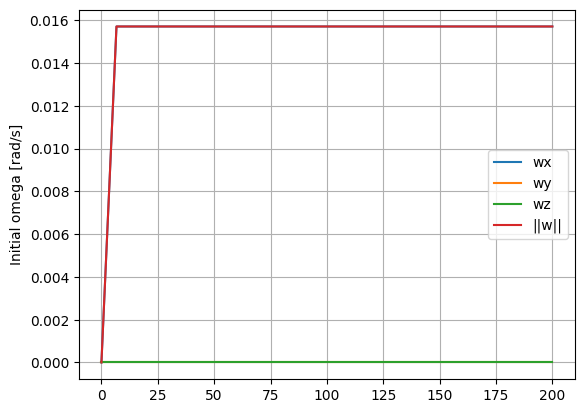

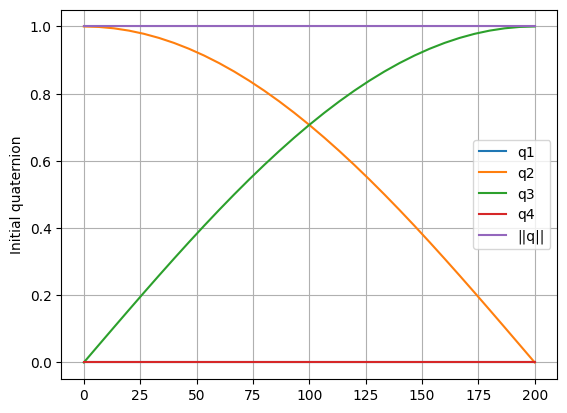

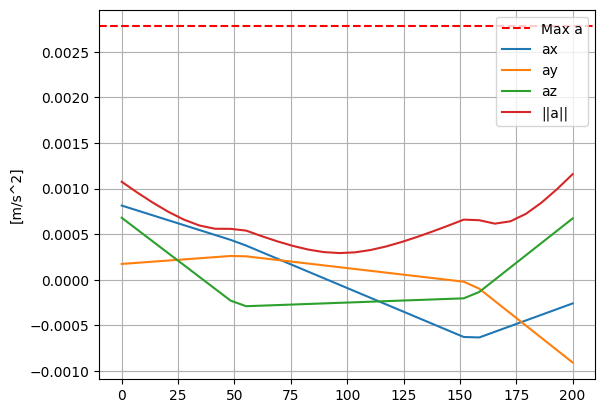

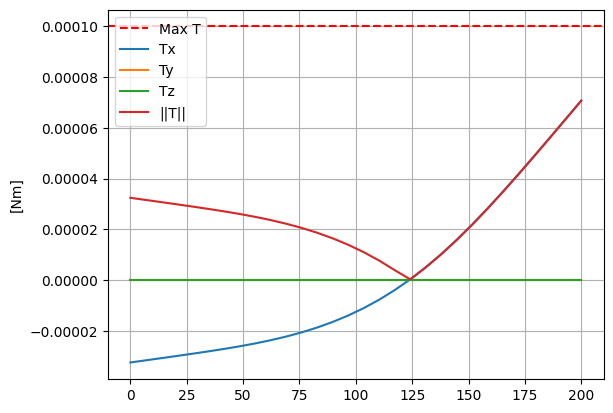

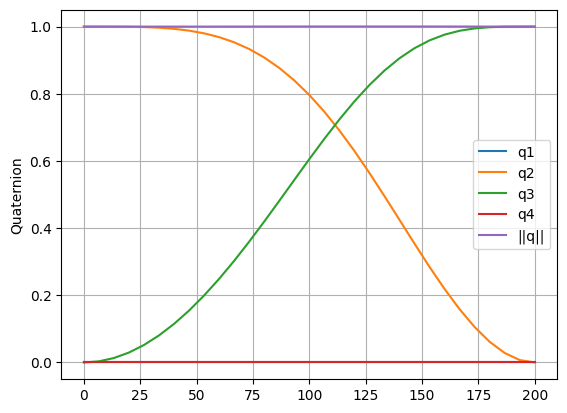

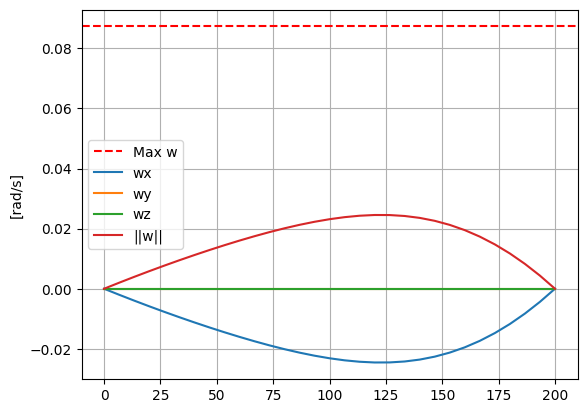

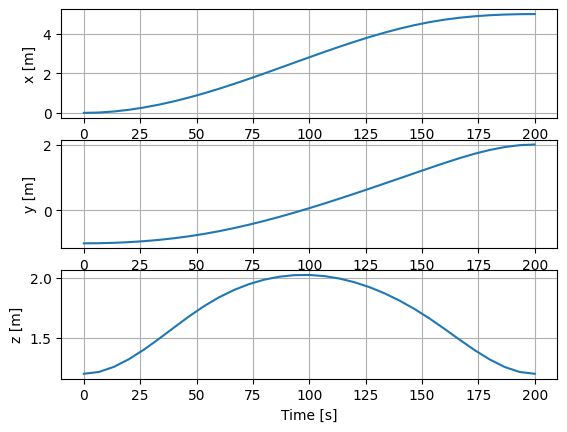

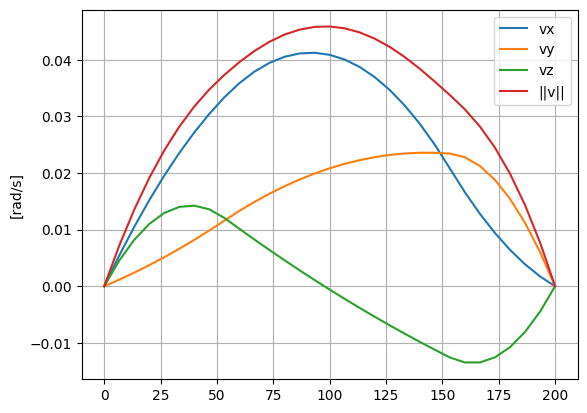

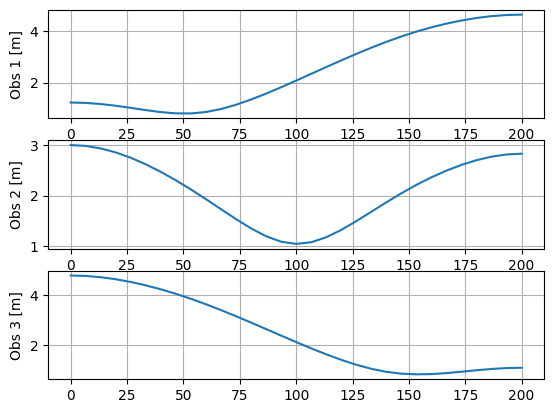

In [41]:
u_value=np.copy(u_global)
nx_value=np.copy(x_global)

plt.figure(2)
plt.plot(np.linspace(0, tf, T+1), ox_angvel[0,:], label='wx')
plt.plot(np.linspace(0, tf, T+1), ox_angvel[1,:], label='wy')
plt.plot(np.linspace(0, tf, T+1), ox_angvel[2,:], label='wz')
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(ox_angvel,axis=0), label='||w||')
plt.ylabel('Initial omega [rad/s]')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(3)
plt.plot(np.linspace(0, tf, T+1), ox_quat[0,:], label='q1')
plt.plot(np.linspace(0, tf, T+1), ox_quat[1,:], label='q2')
plt.plot(np.linspace(0, tf, T+1), ox_quat[2,:], label='q3')
plt.plot(np.linspace(0, tf, T+1), ox_quat[3,:], label='q4')
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(ox_quat,axis=0), label='||q||')
plt.ylabel('Initial quaternion')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(4)
plt.axhline(y=u_max_acc_double, color='r', linestyle='--', label='Max a')
plt.plot(np.linspace(0, tf, T), u_value[0,:], label='ax')
plt.plot(np.linspace(0, tf, T), u_value[1,:], label='ay')
plt.plot(np.linspace(0, tf, T), u_value[2,:], label='az')
plt.plot(np.linspace(0, tf, T), np.linalg.norm(u_value[0:3,:],axis=0), label='||a||')
plt.ylabel('[m/s^2]')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(5)
plt.axhline(y=u_max_torq_double, color='r', linestyle='--', label='Max T')
plt.plot(np.linspace(0, tf, T), u_value[3,:], label='Tx')
plt.plot(np.linspace(0, tf, T), u_value[4,:], label='Ty')
plt.plot(np.linspace(0, tf, T), u_value[5,:], label='Tz')
plt.plot(np.linspace(0, tf, T), np.linalg.norm(u_value[3:6,:],axis=0), label='||T||')
plt.ylabel('[Nm]')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(6)
plt.plot(np.linspace(0, tf, T+1), nx_value[6,:], label='q1')
plt.plot(np.linspace(0, tf, T+1), nx_value[7,:], label='q2')
plt.plot(np.linspace(0, tf, T+1), nx_value[8,:], label='q3')
plt.plot(np.linspace(0, tf, T+1), nx_value[9,:], label='q4')
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(nx_value[6:10,:],axis=0), label='||q||')
plt.ylabel('Quaternion')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(7)
plt.axhline(y=omega_max_double, color='r', linestyle='--', label='Max w')
plt.plot(np.linspace(0, tf, T+1), nx_value[10,:], label='wx')
plt.plot(np.linspace(0, tf, T+1), nx_value[11,:], label='wy')
plt.plot(np.linspace(0, tf, T+1), nx_value[12,:], label='wz')
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(nx_value[10:13,:],axis=0), label='||w||')
plt.ylabel('[rad/s]')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(8)
plt.subplot(311)
plt.plot(np.linspace(0, tf, T+1), nx_value[3,:])
plt.xlabel('Time [s]')
plt.ylabel('x [m]')
plt.grid(True)
plt.subplot(312)
plt.plot(np.linspace(0, tf, T+1), nx_value[4,:])
plt.xlabel('Time [s]')
plt.ylabel('y [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(313)
plt.plot(np.linspace(0, tf, T+1), nx_value[5,:])
plt.xlabel('Time [s]')
plt.ylabel('z [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)

plt.figure(9)
plt.plot(np.linspace(0, tf, T+1), nx_value[0,:], label='vx')
plt.plot(np.linspace(0, tf, T+1), nx_value[1,:], label='vy')
plt.plot(np.linspace(0, tf, T+1), nx_value[2,:], label='vz')
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(nx_value[0:3,:],axis=0), label='||v||')
plt.ylabel('[rad/s]')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(10)
plt.subplot(311)
pos_dron= nx_value[3:6,:]
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(pos_dron-c_obs1_double,axis=0))
plt.ylabel('Obs 1 [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(312)
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(pos_dron-c_obs2_double,axis=0))
plt.ylabel('Obs 2 [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(313)
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(pos_dron-c_obs3_double,axis=0))
plt.ylabel('Obs 3 [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)

plt.show()

In [43]:
import numpy as np
import plotly.graph_objs as go
from scipy.spatial.transform import Rotation as R

def create_cube(center, size, quaternion):
    """Creates a rotated cube using a quaternion."""
    half = size / 2.0
    vertices = np.array([  # Cube vertices
        [-half, -half, -half], [half, -half, -half], [half, half, -half], [-half, half, -half],
        [-half, -half, half], [half, -half, half], [half, half, half], [-half, half, half]
    ])

    # Apply rotation using quaternion
    r = R.from_quat(quaternion)
    rotated_vertices = r.apply(vertices) + center

    # Cube faces (each face as a set of 4 vertices)
    faces = [
        [0, 1, 2, 3], [4, 5, 6, 7], [0, 1, 5, 4],
        [2, 3, 7, 6], [0, 3, 7, 4], [1, 2, 6, 5]
    ]

    # Define mesh faces for the cube
    i_faces = [face[0] for face in faces]
    j_faces = [face[1] for face in faces]
    k_faces = [face[2] for face in faces]
    i_faces += [face[0] for face in faces]
    j_faces += [face[2] for face in faces]
    k_faces += [face[3] for face in faces]

    # Mesh3d for the cube (white cube)
    cube = go.Mesh3d(
        x=rotated_vertices[:, 0], y=rotated_vertices[:, 1], z=rotated_vertices[:, 2],
        i=i_faces, j=j_faces, k=k_faces, opacity=1.0, color='white'
    )

    # Create "eyes" (small blue circles) on the cube's faces
    eye_radius = 0.1
    eye_positions = [
        [half,0.13,0], [half,-0.13,0]
    ]

    # Apply rotation to eye positions
    rotated_eye_positions = r.apply(eye_positions) + center

    eye_spheres = []
    for pos in rotated_eye_positions:
        u, v = np.mgrid[0:2*np.pi:10j, 0:np.pi:5j]
        x_eye = eye_radius * np.cos(u) * np.sin(v) + pos[0]
        y_eye = eye_radius * np.sin(u) * np.sin(v) + pos[1]
        z_eye = eye_radius * np.cos(v) + pos[2]

        # Crear una matriz de color uniforme (por ejemplo, azul con un solo valor)
        color_value = np.full_like(x_eye, 0.5)  # 0.5 es un tono de azul en la escala

        eye_spheres.append(go.Surface(
            x=x_eye, y=y_eye, z=z_eye, surfacecolor=color_value,
            colorscale=[[0, 'deepskyblue'], [1, 'deepskyblue']], opacity=1.0, showscale=False
        ))

    return cube, eye_spheres

def create_spheres(spheres):
    """Creates spheres as surfaces."""
    sphere_traces = []
    for sphere in spheres:
        h, rc = sphere['h'], sphere['rc']
        u, v = np.mgrid[0:2*np.pi:16j, 0:np.pi:8j]
        x_sphere = rc * np.cos(u) * np.sin(v) + h[0]
        y_sphere = rc * np.sin(u) * np.sin(v) + h[1]
        z_sphere = rc * np.cos(v) + h[2]
        sphere_traces.append(go.Surface(
            x=x_sphere, y=y_sphere, z=z_sphere, colorscale='Reds', opacity=0.3, showscale=False
        ))
    return sphere_traces

def plot_3d_trajectory_with_cube(nx_value, spheres):
    quaternions = nx_value[6:10, :]
    x_traj, y_traj, z_traj = nx_value[3, :], nx_value[4, :], nx_value[5, :]

    trace_trajectory = go.Scatter3d(x=x_traj, y=y_traj, z=z_traj, mode='lines',
                                    line=dict(color='blue', width=2))

    # Set axis limits with uniform scaling
    padding = 0.5
    max_range = max(max(x_traj) - min(x_traj), max(y_traj) - min(y_traj), max(z_traj) - min(z_traj)) / 2
    mid_x, mid_y, mid_z = (max(x_traj) + min(x_traj)) / 2, (max(y_traj) + min(y_traj)) / 2, (max(z_traj) + min(z_traj)) / 2
    x_range = [mid_x - max_range - padding, mid_x + max_range + padding]
    y_range = [mid_y - max_range - padding, mid_y + max_range + padding]
    z_range = [mid_z - max_range - padding, mid_z + max_range + padding]

    # Initial cube (white with blue eyes)
    cube, eye_spheres = create_cube([x_traj[0], y_traj[0], z_traj[0]], 0.5, quaternions[:, 0])

    # Initial spheres
    sphere_traces = create_spheres(spheres)

    # Animation frames
    frames = [
        go.Frame(data=[
            go.Scatter3d(x=x_traj, y=y_traj, z=z_traj, mode='lines',
                         marker=dict(size=2, color='blue')),
            create_cube([x_traj[k], y_traj[k], z_traj[k]], 0.5, quaternions[:, k])[0],
        ] + create_spheres(spheres) + create_cube([x_traj[k], y_traj[k], z_traj[k]], 0.5, quaternions[:, k])[1])
        for k in range(len(x_traj))
    ]

    layout = go.Layout(
        title='Astrobee guidance via SCvx (ECOS, CVXpygen)',
        scene=dict(
            xaxis_title='x', yaxis_title='y', zaxis_title='z',
            xaxis=dict(range=x_range, autorange=False),
            yaxis=dict(range=y_range, autorange=False),
            zaxis=dict(range=z_range, autorange=False),
            aspectmode='cube',  # Ensures correct proportions
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))  # Adjust camera view for better visibility
        ),
        updatemenus=[dict(type='buttons', buttons=[dict(label='Play', method='animate',
                                                       args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                        fromcurrent=True)])])])

    fig = go.Figure(data=[trace_trajectory, cube] + sphere_traces + eye_spheres, layout=layout, frames=frames)
    fig.show()

spheres = [
    {'h': c_obs1_double, 'rc': d_obs1_double},
    {'h': c_obs2_double, 'rc': d_obs2_double},
    {'h': c_obs3_double, 'rc': d_obs3_double}
]

plot_3d_trajectory_with_cube(nx_value, spheres)


In [44]:
print(np.linalg.norm(vc.value))

4.028020136338573e-09


# GuSTO Astrobee (ECOS working)

In [45]:
!pip install ecos

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time
import math

print("numpy version",np.__version__)
print("cvxpy version",cp.__version__)

T = 31-1 # 101-1 (mean 101 discretization points)
tf = 200.0
tau = tf/(T)

#Kinematics and dynamics

start_xyz=np.array([[0.0],[-1.0],[1.2]])
end_xyz=np.array([[5.0],[2.0],[1.2]])

start_quat=np.array([[0],[0],[0],[1]])
#end_quat=np.array([[0.3**0.5],[0.4**0.5],[0.1**0.5],[0.2**0.5]])
#end_quat=np.array([[0],[0],[0],[1]])
#end_quat=np.array([[0],[0],[1],[0]])
end_quat=np.array([[1],[0],[0],[0]])

startpos=np.block([[0.0],[0.0],[0.0],[start_xyz],[start_quat],[0],[0],[0]])
endpos=np.block([[0.0],[0.0],[0.0],[end_xyz],[end_quat],[0],[0],[0]])

c_obs1_double = np.array([[1.1],[-0.5],[1]])
c_obs2_double = np.array([[2.6],[0.5],[1.1]])
c_obs3_double = np.array([[4],[1.6],[1.2]])

d_obs1_double = 0.8
d_obs2_double = 0.8
d_obs3_double = 0.8

J1_double=0.1083
J2_double=0.1083
J3_double=0.1083

u_max_acc_double = 20/7.2*0.001
#u_max_torq_double = 100*0.0000002
u_max_torq_double = 100*0.000001

vel_max_double = 0.4
#omega_max_double = 3.0*np.pi/180
omega_max_double = 0.021

A = np.array([[0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [1, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0]])
B = np.vstack((np.eye(3), np.zeros((3, 3))))

#Guidance parameters
lambda_0=10**4
lambda_max=10**9
etta_double=5

rho0=0.1
rho1=0.9

etta0=0.001
etta1=10

lamb_double=lambda_0
sqrt_lamb_double=np.sqrt(lambda_0)
etta_double=10
obs_tol_double=0.005 #5mm (useful for lambda_update)

beta_sh=2
beta_gr=2

gamma_fail=5
mu=0.8
k_star=6

e_tol=0.024 #stopping threshold related to Delta_u
epsilon_r=0.05 #stopping threshold related to Delta_J

trapz_Deltau=100000 #Big initial value
J_GuSTO_stop=100000 #Big initial value
J_lamb_old=1 #Initial value (1 recommended)

u_CW_scaling=np.array([[1/u_max_acc_double,0,0],[0,1/u_max_acc_double,0],[0,0,1/u_max_acc_double]])
u_qw_scaling=np.array([[1/u_max_torq_double,0,0],[0,1/u_max_torq_double,0],[0,0,1/u_max_torq_double]])

numpy version 2.2.6
cvxpy version 1.7.3


In [3]:
nx = cp.Variable((13, T + 1), name='nx')
u = cp.Variable((6, T), name='u')

startpos_cvxpy = cp.Parameter((13,1), name='startpos_cvxpy')
endpos_cvxpy = cp.Parameter((13,1), name='endpos_cvxpy')

ox_aux = cp.Parameter((13,T + 1), name='ox_aux')
ox_cvxpy = cp.Parameter((13,T + 1), name='ox_cvxpy')

aux_a_obs1 = cp.Parameter((T+1,1), name='aux_a_obs1')
aux_b_obs1 = cp.Parameter((T+1,3), name='aux_b_obs1')

aux_a_obs2 = cp.Parameter((T+1,1), name='aux_a_obs2')
aux_b_obs2 = cp.Parameter((T+1,3), name='aux_b_obs2')

aux_a_obs3 = cp.Parameter((T+1,1), name='aux_a_obs3')
aux_b_obs3 = cp.Parameter((T+1,3), name='aux_b_obs3')

A_discrete_CW = cp.Parameter((6,6), name='A_discrete_CW')
B_discrete_CW_scaled = cp.Parameter((6,3), name='B_discrete_CW_scaled')

A_discrete_qw = cp.Parameter((7,7*T), name='A_discrete_qw')
B_discrete_qw_scaled = cp.Parameter((7,3*T), name='B_discrete_qw_scaled')
w_discrete_qw = cp.Parameter((7,T), name='w_discrete_qw')

sqrt_lamb = cp.Parameter(name='sqrt_lamb')
sqrtlamb_etta = cp.Parameter(name='sqrtlamb_etta')

a_max = cp.Parameter(name='a_max')
aux_g = cp.Parameter((6,1), name='aux_g')

sqrt_lamb_vel_max = cp.Parameter(name='sqrt_lamb_vel_max')
sqrt_lamb_omega_max = cp.Parameter(name='sqrt_lamb_omega_max')

constraints = [
    nx[:, 0] == startpos_cvxpy[:,0],
    nx[:, T] == endpos_cvxpy[:,0],
]
cost = 0

for k in range(0, T): # from 0 to T-1
    constraints += [nx[0:6, k+1] == A_discrete_CW @ nx[0:6, k] + B_discrete_CW_scaled @ (u[0:3, k])]
    constraints += [nx[6:13, k+1] == A_discrete_qw[:,7*k:7*k+7] @ nx[6:13, k] + B_discrete_qw_scaled[:,3*k:3*k+3] @ (u[3:6, k]) + w_discrete_qw[:,k]]

    constraints += [cp.norm(u[0:3, k], 2) <= 1]
    constraints += [cp.norm(u[3:6, k], 2) <= 1]

    cost += tau*cp.sum_squares(u[0:3,k])
    cost += tau*cp.sum_squares(u[3:6,k])

for k in range(0, T+1):
    cost += tau*cp.power(cp.pos(cp.sum([cp.norm(sqrt_lamb*nx[:, k]-ox_aux[:,k],'inf'),-sqrtlamb_etta])),2) #g_tr

    cost += tau*cp.power(cp.pos(aux_a_obs1[k,0]+aux_b_obs1[k,:]@nx[3:6, k]),2) #sum_n_s obs 1
    cost += tau*cp.power(cp.pos(aux_a_obs2[k,0]+aux_b_obs2[k,:]@nx[3:6, k]),2) #sum_n_s obs 2
    cost += tau*cp.power(cp.pos(aux_a_obs3[k,0]+aux_b_obs3[k,:]@nx[3:6, k]),2) #sum_n_s obs 3

    cost += tau*cp.power(cp.pos(cp.norm(sqrt_lamb*nx[0:3,k:k+1], 2)-sqrt_lamb_vel_max),2) #sum_nw v<=v_max
    cost += tau*cp.power(cp.pos(cp.norm(sqrt_lamb*nx[10:13,k:k+1], 2)-sqrt_lamb_omega_max),2) #sum_nw w<=w_max
objective = cp.Minimize(cost)
problem = cp.Problem(objective, constraints)

In [4]:
print("Is DPP? ", problem.is_dcp(dpp=True))

Is DPP?  True


In [5]:
aux_aux_a_obs1 = np.zeros((T+1,1))
aux_aux_b_obs1 = np.zeros((T+1,3))

aux_aux_a_obs2 = np.zeros((T+1,1))
aux_aux_b_obs2 = np.zeros((T+1,3))

aux_aux_a_obs3 = np.zeros((T+1,1))
aux_aux_b_obs3 = np.zeros((T+1,3))

aux_A_discrete_qw = np.zeros((7,7*T))
aux_B_discrete_qw_scaled = np.zeros((7,3*T))
aux_w_discrete_qw = np.zeros((7,T))

In [6]:
from scipy.spatial.transform import Rotation as R, Slerp

def scaling_begin(u,u_scaling,T):
    for k in range(0, T):
        u[:,k:k+1]=u_scaling@u[:,k:k+1]
    return u
def scaling_end(u,u_scaling,T):
    for k in range(0, T):
        u[:,k:k+1]=np.linalg.inv(u_scaling)@u[:,k:k+1]
    return u
def slerp(q1, q2, num_samples):
    dot = np.dot(q1, q2)
    if dot < 0.0:
        q2 = -q2
        dot = -dot
    dot = np.clip(dot, -1.0, 1.0)
    theta_0 = np.arccos(dot)

    if np.abs(theta_0) < 1e-6:
        return np.linspace(q1, q2, num_samples)

    sin_theta_0 = np.sin(theta_0)

    quaternions = []
    for i in range(num_samples):
        t = i / (num_samples - 1)
        theta = theta_0 * t
        sin_theta = np.sin(theta)
        s0 = np.cos(theta) - dot * sin_theta / sin_theta_0
        s1 = sin_theta / sin_theta_0
        quaternions.append(s0 * q1 + s1 * q2)

    return np.array(quaternions)

def compute_angular_velocity(quaternions, dt):

    rotations = R.from_quat(quaternions)
    angular_velocities = [[0,0,0]]

    for i in range(len(rotations) - 1):
        delta_rot = rotations[i + 1] * rotations[i].inv()
        log_rot = delta_rot.as_rotvec() / dt
        angular_velocities.append(log_rot)

    return np.array(angular_velocities)

def exp_matrix_taylor_A(A,h,n):
    size_n,size_aux=np.shape(A)
    sum=np.eye(size_n)+A*h
    for i in range(2,n+2,1):
        sum=sum+1/math.factorial(i)*np.linalg.matrix_power(h*A,i)
    return sum

def exp_matrix_taylor_B(A,B,h,n):
    size_n,size_aux=np.shape(A)
    sum=h*np.eye(size_n)
    for i in range(2,n+2,1):
        sum=sum+1/math.factorial(i)*np.linalg.matrix_power(A,i-1)*h**i
    return sum@B

def f_qw(x,u):
    aux_f=np.zeros((7,1))

    oq1=x[0,0]
    oq2=x[1,0]
    oq3=x[2,0]
    oq4=x[3,0]
    ow1=x[4,0]
    ow2=x[5,0]
    ow3=x[6,0]

    ou1=u[0,0]
    ou2=u[1,0]
    ou3=u[2,0]

    aux_f[0,0]=0.5*(oq4*ow1-oq3*ow2+oq2*ow3)
    aux_f[1,0]=0.5*(oq3*ow1+oq4*ow2-oq1*ow3)
    aux_f[2,0]=0.5*(-oq2*ow1+oq1*ow2+oq4*ow3)
    aux_f[3,0]=0.5*(-oq1*ow1-oq2*ow2-oq3*ow3)

    aux_f[4,0]=(1/J1_double)*(-(J3_double-J2_double)*ow2*ow3+ou1)
    aux_f[5,0]=(1/J2_double)*(-(J1_double-J3_double)*ow3*ow1+ou2)
    aux_f[6,0]=(1/J3_double)*(-(J2_double-J1_double)*ow1*ow2+ou3)
    return aux_f

def A_qw(oxqw):
  oq1=oxqw[0,0]
  oq2=oxqw[1,0]
  oq3=oxqw[2,0]
  oq4=oxqw[3,0]
  ow1=oxqw[4,0]
  ow2=oxqw[5,0]
  ow3=oxqw[6,0]
  aux_A_qw=np.zeros((7,7))
  aux_A_qw[0:4,:]=0.5*np.array([[0,ow3,-ow2,ow1,oq4,-oq3,oq2],
                            [-ow3,0,ow1,ow2,oq3,oq4,-oq1],
                            [ow2,-ow1,0,ow3,-oq2,oq1,oq4],
                            [-ow1,-ow2,-ow3,0,-oq1,-oq2,-oq3]])
  aux_A_qw[4:7,:] = np.array([
                     [0,0,0,0,0,1/J1_double*(-(J3_double-J2_double)*ow3),1/J1_double*(-(J3_double-J2_double)*ow2)],
                     [0,0,0,0,1/J2_double*(-(J1_double-J3_double)*ow3),0,1/J2_double*(-(J1_double-J3_double)*ow1)],
                     [0,0,0,0,1/J3_double*(-(J2_double-J1_double)*ow2),1/J3_double*(-(J2_double-J1_double)*ow1),0]])
  return aux_A_qw
def B_qw(oxqw):
  aux_B_qw = np.block([[np.zeros((4,3))],[1/J1_double,0,0],[0,1/J2_double,0],[0,0,1/J3_double]])
  return aux_B_qw
def w_qw(oxqw,ou):
  aux_w_qw=f_qw(oxqw,ou)-A_qw(oxqw)@oxqw
  return aux_w_qw

ox_pos = np.column_stack((np.array([np.linspace(startpos[3,0], endpos[3,0], T+1), np.linspace(startpos[4,0], endpos[4,0], T+1),np.linspace(startpos[5,0], endpos[5,0], T+1)]))).T
ox_vel = np.zeros(np.shape(ox_pos))

for t in range(1, T + 1):
    ox_vel[:, t] = (ox_pos[:, t] - ox_pos[:, t - 1])/tau

ox_quat = slerp(startpos[6:10,0], endpos[6:10,0],T+1).T
ox_angvel = compute_angular_velocity(ox_quat.T, tau).T

ox=np.zeros((13,T+1))
ox[0:6,:]=np.block([[ox_vel],[ox_pos]])
ox[6:10,:]=ox_quat
ox[10:13,:]=ox_angvel

ou=np.zeros((6,T))

A_discrete_CW.value = exp_matrix_taylor_A(A,tau,7)
B_discrete_CW_scaled.value = exp_matrix_taylor_B(A,B@np.linalg.inv(u_CW_scaling),tau,7)

sqrt_lamb_vel_max.value=lamb_double**0.5*vel_max_double
sqrt_lamb_omega_max.value=lamb_double**0.5*omega_max_double

In [7]:
def h_lambda(z):
  if z>=0:
    return lamb_double*z**2
  if z<0:
    return 0
def lamb_update(lamb,x_opt,T):
    obs1_bool=True
    obs2_bool=True
    obs3_bool=True
    wmax_bool=True
    vmax_bool=True
    for k in range(0,T+1,1):
        obs1_bool=(np.linalg.norm(x_opt[3:6,k:k+1]-c_obs1_double,ord=2)>=d_obs1_double-obs_tol_double) and obs1_bool #obs1
        obs2_bool=(np.linalg.norm(x_opt[3:6,k:k+1]-c_obs2_double,ord=2)>=d_obs2_double-obs_tol_double) and obs2_bool #obs2
        obs3_bool=(np.linalg.norm(x_opt[3:6,k:k+1]-c_obs3_double,ord=2)>=d_obs3_double-obs_tol_double) and obs3_bool #obs3

        vmax_bool=(np.linalg.norm(x_opt[0:3,k:k+1])<=vel_max_double) and vmax_bool #v<=vmax
        wmax_bool=(np.linalg.norm(x_opt[10:13,k:k+1])<=omega_max_double) and wmax_bool #w<=wmax

        if not(obs1_bool) or not(obs2_bool) or not(obs3_bool) or not(wmax_bool) or not(vmax_bool):
            break;
    if obs1_bool and obs2_bool and obs3_bool and vmax_bool and wmax_bool:
        return lambda_0
    else:
        return gamma_fail*lamb

def sum_x_star_and_Theta_star(x_opt,u_opt,T):
    dx_k_star=np.zeros((13,1))
    A_discrete_CW_GuSTO=exp_matrix_taylor_A(A,tau,7)
    B_discrete_CW_GuSTO=exp_matrix_taylor_B(A,B@np.linalg.inv(u_CW_scaling),tau,7)

    sum_x=0
    Theta_sum=0

    for k in range(0,T,1):
        A_qw_c = A_qw(x_opt[6:13, k:k+1]) #continuous time
        B_qw_c = B_qw(x_opt[6:13,k:k+1])@np.linalg.inv(u_qw_scaling) #continuous time
        w_qw_c = w_qw(x_opt[6:13,k:k+1],np.zeros((3,1))) #continuous time

        dx_k_star[0:6,:]=A@x_opt[0:6, k:k+1]+B@np.linalg.inv(u_CW_scaling)@u_opt[0:3, k:k+1]
        dx_k_star[6:13,:]=A_qw_c @ x_opt[6:13, k:k+1] + B_qw_c @ np.linalg.inv(u_qw_scaling) @ (u_opt[3:6, k:k+1]) + w_qw_c

        sum_x+=tau*np.linalg.norm(dx_k_star,ord=2)

        u_opt[0:3,:] = scaling_end(u_opt[0:3,:],u_CW_scaling,T) #scaling end
        u_opt[3:6,:] = scaling_end(u_opt[3:6,:],u_qw_scaling,T) #scaling end
        Theta_sum+=tau*np.linalg.norm(np.block([[np.zeros((6,1))],[f_qw(x_opt[6:13, k:k+1],u_opt[3:6, k:k+1])]])-dx_k_star,ord=2)
        u_opt[0:3,:] = scaling_begin(u_opt[0:3,:],u_CW_scaling,T) #scaling begin
        u_opt[3:6,:] = scaling_begin(u_opt[3:6,:],u_qw_scaling,T) #scaling begin

    return [sum_x,Theta_sum]
def J_lamb_GuSTO(x,u,etta,T):
    cost1 = 0
    cost2 = 0
    cost3 = 0
    for k in range(0, T): # from 0 to T-1
        cost1+=tau*np.linalg.norm(u[:,k:k+1], ord=2)**2
    for k in range(0, T+1):
        cost2 += tau*h_lambda(np.linalg.norm(x[:,k:k+1]-ox[:,k:k+1], ord=np.inf)-etta)
    for k in range(0, T+1):
        cost3 += tau*h_lambda(-np.linalg.norm(x[3:6,k:k+1]-c_obs1_double, ord=2)+d_obs1_double)
        cost3 += tau*h_lambda(-np.linalg.norm(x[3:6,k:k+1]-c_obs2_double, ord=2)+d_obs2_double)
        cost3 += tau*h_lambda(-np.linalg.norm(x[3:6,k:k+1]-c_obs3_double, ord=2)+d_obs3_double)

        cost3 += tau*h_lambda(np.linalg.norm(x[0:3,k:k+1], ord=2)-vel_max_double) #sum_nw v<=v_max
        cost3 += tau*h_lambda(np.linalg.norm(x[10:13,k:k+1], ord=2)-omega_max_double) #sum_nw w<=w_max

    return cost1+cost2+cost3

startpos_cvxpy.value=np.copy(startpos)
endpos_cvxpy.value=np.copy(endpos)

t0 = time.time()

lamb_double = lamb_double
sqrt_lamb.value = (lamb_double)**0.5
etta_double = etta_double
sqrtlamb_etta.value = (lamb_double)**0.5*etta_double

ox_cvxpy.value = np.copy(ox) #trajectory initialization (control)
ox_aux.value = (lamb_double)**0.5*ox

ou = np.zeros((6,T)) #trajectory initialization (input)

ou[0:3,:] = scaling_begin(ou[0:3,:],u_CW_scaling,T) #scaling begin
ou[3:6,:] = scaling_begin(ou[3:6,:],u_qw_scaling,T) #scaling begin

i=1
while True:
    if lamb_double>lambda_max or (trapz_Deltau<e_tol) or J_GuSTO_stop<epsilon_r:
        u_global = ou
        x_global = ox
        u_global[0:3,:] = scaling_end(u_global[0:3,:],u_CW_scaling,T) #scaling end
        u_global[3:6,:] = scaling_end(u_global[3:6,:],u_qw_scaling,T) #scaling end
        trapz_Deltau=100000 #Big initial value
        J_GuSTO_stop=100000 #Big initial value
        break;

    ou[0:3,:] = scaling_end(ou[0:3,:],u_CW_scaling,T) #scaling end
    ou[3:6,:] = scaling_end(ou[3:6,:],u_qw_scaling,T) #scaling end

    for k in range(0, T):
        aux_A_discrete_qw[0:7,7*k:7*k+7] = exp_matrix_taylor_A(A_qw(ox[6:13,k:k+1]),tau,7)
        aux_B_discrete_qw_scaled[0:7,3*k:3*k+3] = exp_matrix_taylor_B(A_qw(ox[6:13,k:k+1]),B_qw(ox[6:13,k:k+1])@np.linalg.inv(u_qw_scaling),tau,7)
        aux_w_discrete_qw[0:7,k:k+1] = exp_matrix_taylor_B(A_qw(ox[6:13,k:k+1]),w_qw(ox[6:13,k:k+1],np.zeros((3,1))),tau,7)

    A_discrete_qw.value = np.copy(aux_A_discrete_qw)
    B_discrete_qw_scaled.value = np.copy(aux_B_discrete_qw_scaled)
    w_discrete_qw.value = np.copy(aux_w_discrete_qw)

    for k in range(0,T+1,1):
        aux_aux_a_obs1[k,0] = -np.sqrt(lamb_double)*np.linalg.norm(ox[3:6,k]-c_obs1_double[:,0],2)+np.sqrt(lamb_double)*d_obs1_double+np.sqrt(lamb_double)*(ox[3:6,k]-c_obs1_double[:,0]).T/(np.linalg.norm(ox[3:6,k]-c_obs1_double[:,0],2))@ox[3:6,k]
        aux_aux_b_obs1[k:k+1,:] = -np.sqrt(lamb_double)*(ox[3:6,k]-c_obs1_double[:,0]).T/(np.linalg.norm(ox[3:6,k]-c_obs1_double[:,0],2))

        aux_aux_a_obs2[k,0] = -np.sqrt(lamb_double)*np.linalg.norm(ox[3:6,k]-c_obs2_double[:,0],2)+np.sqrt(lamb_double)*d_obs2_double+np.sqrt(lamb_double)*(ox[3:6,k]-c_obs2_double[:,0]).T/(np.linalg.norm(ox[3:6,k]-c_obs2_double[:,0],2))@ox[3:6,k]
        aux_aux_b_obs2[k:k+1,:] = -np.sqrt(lamb_double)*(ox[3:6,k]-c_obs2_double[:,0]).T/(np.linalg.norm(ox[3:6,k]-c_obs2_double[:,0],2))

        aux_aux_a_obs3[k,0] = -np.sqrt(lamb_double)*np.linalg.norm(ox[3:6,k]-c_obs3_double[:,0],2)+np.sqrt(lamb_double)*d_obs3_double+np.sqrt(lamb_double)*(ox[3:6,k]-c_obs3_double[:,0]).T/(np.linalg.norm(ox[3:6,k]-c_obs3_double[:,0],2))@ox[3:6,k]
        aux_aux_b_obs3[k:k+1,:] = -np.sqrt(lamb_double)*(ox[3:6,k]-c_obs3_double[:,0]).T/(np.linalg.norm(ox[3:6,k]-c_obs3_double[:,0],2))

    aux_a_obs1.value=np.copy(aux_aux_a_obs1)
    aux_b_obs1.value=np.copy(aux_aux_b_obs1)

    aux_a_obs2.value=np.copy(aux_aux_a_obs2)
    aux_b_obs2.value=np.copy(aux_aux_b_obs2)

    aux_a_obs3.value=np.copy(aux_aux_a_obs3)
    aux_b_obs3.value=np.copy(aux_aux_b_obs3)

    val = problem.solve(solver='ECOS', ignore_dpp=True)
    L_lambda=val
    x_opt = nx.value
    u_opt = u.value

    ou[0:3,:] = scaling_begin(ou[0:3,:],u_CW_scaling,T) #scaling begin
    ou[3:6,:] = scaling_begin(ou[3:6,:],u_qw_scaling,T) #scaling begin

    trapz_Deltau=0
    for k in range(0,T,1):
        trapz_Deltau+=tau*np.linalg.norm(u_opt[:, k:k+1]-ou[:, k:k+1], ord=np.inf)

    J_lamb_opt=J_lamb_GuSTO(x_opt,u_opt,etta_double,T)
    J_GuSTO_stop=np.abs(J_lamb_old-J_lamb_opt)/np.abs(J_lamb_old)

    flag_case4=True
    for k in range(0,T+1,1):
        if np.linalg.norm(x_opt[:, k:k+1]-ox[:, k:k+1], ord=np.inf)>etta_double:
            print("Case 4")
            etta_double=etta_double
            ox=ox
            ou=ou
            lamb_double=gamma_fail*lamb_double
            flag_case4=False
            break;

    if flag_case4:
      sum_x_star, Theta_star = sum_x_star_and_Theta_star(x_opt,u_opt,T)
      rho_i=(abs(J_lamb_opt-L_lambda)+Theta_star)/(abs(L_lambda)+sum_x_star)
      print("J_lamb_GuSTO: ",J_lamb_GuSTO(x_opt,u_opt,etta_double,T)," L_lambda: ",L_lambda," rho:",rho_i)
      if rho_i<rho0:
          etta_double=min([etta1,beta_gr*etta_double])
          ox = np.copy(x_opt)
          ou = np.copy(u_opt)
          lamb_double=lamb_update(lamb_double,x_opt,T)
          print("Case 1")
      if rho_i>=rho0 and rho_i<rho1:
          etta_double=etta_double
          ox = np.copy(x_opt)
          ou = np.copy(u_opt)
          lamb_double=lamb_update(lamb_double,x_opt,T)
          print("Case 2")
      if rho_i>=rho1:
          etta_double=max([etta0,etta_double/beta_sh])
          ox=np.copy(ox)
          ou=np.copy(ou)
          lamb_double=lamb_double
          print("Case 3")

    sqrtlamb_etta.value = (lamb_double)**0.5*etta_double

    ox_aux.value = (lamb_double)**0.5*ox
    sqrt_lamb.value=(lamb_double)**0.5
    sqrt_lamb_vel_max.value=(lamb_double)**0.5*vel_max_double
    sqrt_lamb_omega_max.value=(lamb_double)**0.5*omega_max_double

    J_lamb_old=J_lamb_GuSTO(ox,ou,etta_double,T)
    print(" Iteration number: ",i," Cost function: ", val," Etta: ",etta_double,"Lambda: ",lamb_double,"Trap_Du: ",trapz_Deltau, "J_stop: ",J_GuSTO_stop)
    i=i+1

t1 = time.time()
print('\nCVXPY\nSolve time: %.3f ms' % (1000 * (t1 - t0)))

J_lamb_GuSTO:  55.766922803830646  L_lambda:  55.77629000584824  rho: 0.11874377520901165
Case 2
 Iteration number:  1  Cost function:  55.77629000584824  Etta:  10 Lambda:  50000 Trap_Du:  75.59886138943858 J_stop:  54.766922803830646
J_lamb_GuSTO:  32.759383808932895  L_lambda:  32.759575223762305  rho: 0.166189043287748
Case 2
 Iteration number:  2  Cost function:  32.759575223762305  Etta:  10 Lambda:  250000 Trap_Du:  42.306720482891194 J_stop:  0.4280452569468509
J_lamb_GuSTO:  32.62132594508588  L_lambda:  32.621341213029666  rho: 0.16241065880679978
Case 2
 Iteration number:  3  Cost function:  32.621341213029666  Etta:  10 Lambda:  1250000 Trap_Du:  10.082189205344054 J_stop:  0.014921110308569095

CVXPY
Solve time: 2315.466 ms


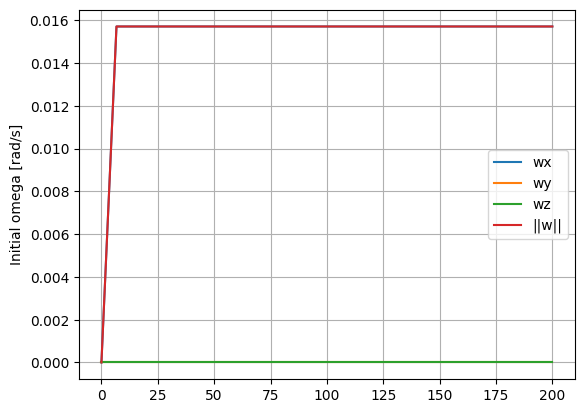

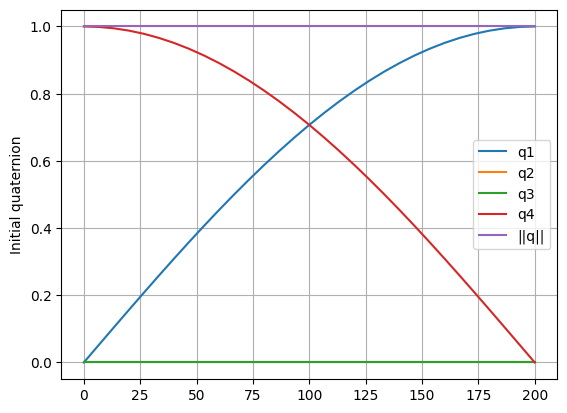

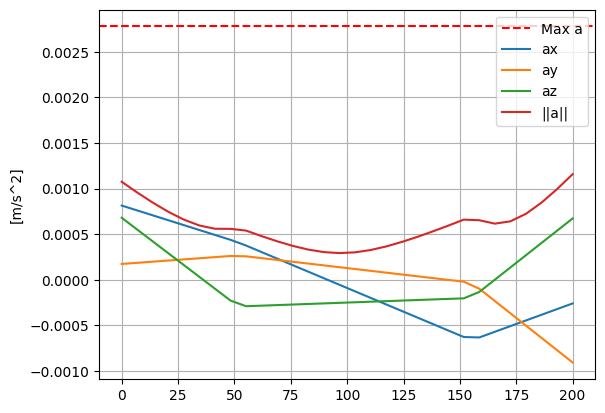

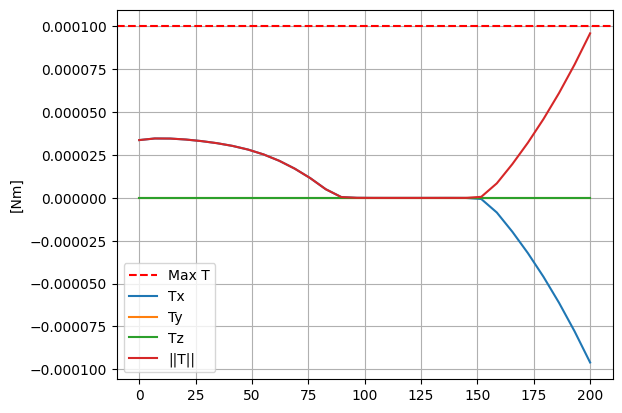

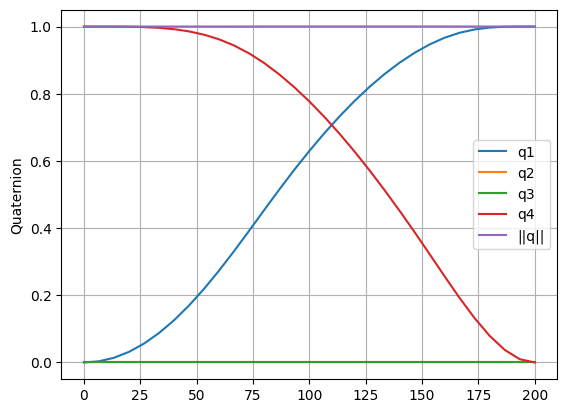

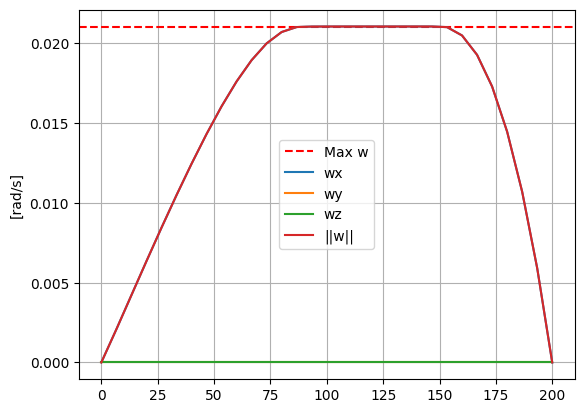

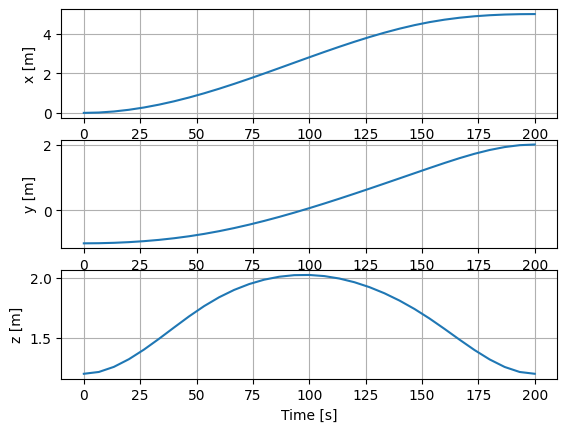

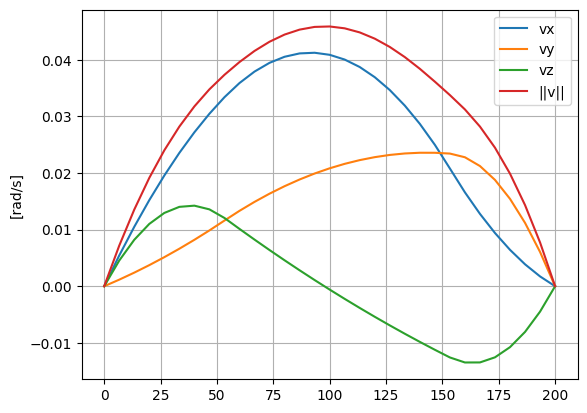

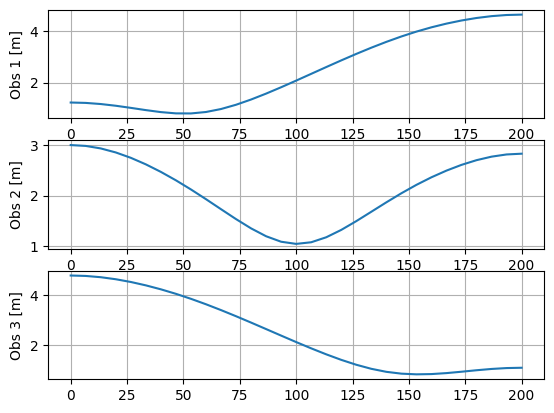

In [8]:
u_value=np.copy(u_global)
nx_value=np.copy(x_global)

plt.figure(2)
plt.plot(np.linspace(0, tf, T+1), ox_angvel[0,:], label='wx')
plt.plot(np.linspace(0, tf, T+1), ox_angvel[1,:], label='wy')
plt.plot(np.linspace(0, tf, T+1), ox_angvel[2,:], label='wz')
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(ox_angvel,axis=0), label='||w||')
plt.ylabel('Initial omega [rad/s]')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(3)
plt.plot(np.linspace(0, tf, T+1), ox_quat[0,:], label='q1')
plt.plot(np.linspace(0, tf, T+1), ox_quat[1,:], label='q2')
plt.plot(np.linspace(0, tf, T+1), ox_quat[2,:], label='q3')
plt.plot(np.linspace(0, tf, T+1), ox_quat[3,:], label='q4')
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(ox_quat,axis=0), label='||q||')
plt.ylabel('Initial quaternion')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(4)
plt.axhline(y=u_max_acc_double, color='r', linestyle='--', label='Max a')
plt.plot(np.linspace(0, tf, T), u_value[0,:], label='ax')
plt.plot(np.linspace(0, tf, T), u_value[1,:], label='ay')
plt.plot(np.linspace(0, tf, T), u_value[2,:], label='az')
plt.plot(np.linspace(0, tf, T), np.linalg.norm(u_value[0:3,:],axis=0), label='||a||')
plt.ylabel('[m/s^2]')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(5)
plt.axhline(y=u_max_torq_double, color='r', linestyle='--', label='Max T')
plt.plot(np.linspace(0, tf, T), u_value[3,:], label='Tx')
plt.plot(np.linspace(0, tf, T), u_value[4,:], label='Ty')
plt.plot(np.linspace(0, tf, T), u_value[5,:], label='Tz')
plt.plot(np.linspace(0, tf, T), np.linalg.norm(u_value[3:6,:],axis=0), label='||T||')
plt.ylabel('[Nm]')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(6)
plt.plot(np.linspace(0, tf, T+1), nx_value[6,:], label='q1')
plt.plot(np.linspace(0, tf, T+1), nx_value[7,:], label='q2')
plt.plot(np.linspace(0, tf, T+1), nx_value[8,:], label='q3')
plt.plot(np.linspace(0, tf, T+1), nx_value[9,:], label='q4')
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(nx_value[6:10,:],axis=0), label='||q||')
plt.ylabel('Quaternion')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(7)
plt.axhline(y=omega_max_double, color='r', linestyle='--', label='Max w')
plt.plot(np.linspace(0, tf, T+1), nx_value[10,:], label='wx')
plt.plot(np.linspace(0, tf, T+1), nx_value[11,:], label='wy')
plt.plot(np.linspace(0, tf, T+1), nx_value[12,:], label='wz')
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(nx_value[10:13,:],axis=0), label='||w||')
plt.ylabel('[rad/s]')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(8)
plt.subplot(311)
plt.plot(np.linspace(0, tf, T+1), nx_value[3,:])
plt.xlabel('Time [s]')
plt.ylabel('x [m]')
plt.grid(True)
plt.subplot(312)
plt.plot(np.linspace(0, tf, T+1), nx_value[4,:])
plt.xlabel('Time [s]')
plt.ylabel('y [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(313)
plt.plot(np.linspace(0, tf, T+1), nx_value[5,:])
plt.xlabel('Time [s]')
plt.ylabel('z [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)

plt.figure(9)
plt.plot(np.linspace(0, tf, T+1), nx_value[0,:], label='vx')
plt.plot(np.linspace(0, tf, T+1), nx_value[1,:], label='vy')
plt.plot(np.linspace(0, tf, T+1), nx_value[2,:], label='vz')
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(nx_value[0:3,:],axis=0), label='||v||')
plt.ylabel('[rad/s]')
plt.gca().tick_params(labelsize=10)
plt.legend()
plt.grid(True)

plt.figure(10)
plt.subplot(311)
pos_dron= nx_value[3:6,:]
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(pos_dron-c_obs1_double,axis=0))
plt.ylabel('Obs 1 [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(312)
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(pos_dron-c_obs2_double,axis=0))
plt.ylabel('Obs 2 [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)
plt.subplot(313)
plt.plot(np.linspace(0, tf, T+1), np.linalg.norm(pos_dron-c_obs3_double,axis=0))
plt.ylabel('Obs 3 [m]')
plt.gca().tick_params(labelsize=10)
plt.grid(True)

plt.show()
u_global[0:3,:] = scaling_begin(u_global[0:3,:],u_CW_scaling,T) #scaling begin
u_global[3:6,:] = scaling_begin(u_global[3:6,:],u_qw_scaling,T) #scaling begin

In [9]:
import numpy as np
import plotly.graph_objs as go
from scipy.spatial.transform import Rotation as R

def create_cube(center, size, quaternion):
    """Creates a rotated cube using a quaternion."""
    half = size / 2.0
    vertices = np.array([  # Cube vertices
        [-half, -half, -half], [half, -half, -half], [half, half, -half], [-half, half, -half],
        [-half, -half, half], [half, -half, half], [half, half, half], [-half, half, half]
    ])

    # Apply rotation using quaternion
    r = R.from_quat(quaternion)
    rotated_vertices = r.apply(vertices) + center

    # Cube faces (each face as a set of 4 vertices)
    faces = [
        [0, 1, 2, 3], [4, 5, 6, 7], [0, 1, 5, 4],
        [2, 3, 7, 6], [0, 3, 7, 4], [1, 2, 6, 5]
    ]

    # Define mesh faces for the cube
    i_faces = [face[0] for face in faces]
    j_faces = [face[1] for face in faces]
    k_faces = [face[2] for face in faces]
    i_faces += [face[0] for face in faces]
    j_faces += [face[2] for face in faces]
    k_faces += [face[3] for face in faces]

    # Mesh3d for the cube (white cube)
    cube = go.Mesh3d(
        x=rotated_vertices[:, 0], y=rotated_vertices[:, 1], z=rotated_vertices[:, 2],
        i=i_faces, j=j_faces, k=k_faces, opacity=1.0, color='white'
    )

    # Create "eyes" (small blue circles) on the cube's faces
    eye_radius = 0.1
    eye_positions = [
        [half,0.13,0], [half,-0.13,0]
    ]

    # Apply rotation to eye positions
    rotated_eye_positions = r.apply(eye_positions) + center

    eye_spheres = []
    for pos in rotated_eye_positions:
        u, v = np.mgrid[0:2*np.pi:10j, 0:np.pi:5j]
        x_eye = eye_radius * np.cos(u) * np.sin(v) + pos[0]
        y_eye = eye_radius * np.sin(u) * np.sin(v) + pos[1]
        z_eye = eye_radius * np.cos(v) + pos[2]

        # Crear una matriz de color uniforme (por ejemplo, azul con un solo valor)
        color_value = np.full_like(x_eye, 0.5)  # 0.5 es un tono de azul en la escala

        eye_spheres.append(go.Surface(
            x=x_eye, y=y_eye, z=z_eye, surfacecolor=color_value,
            colorscale=[[0, 'deepskyblue'], [1, 'deepskyblue']], opacity=1.0, showscale=False
        ))

    return cube, eye_spheres

def create_spheres(spheres):
    """Creates spheres as surfaces."""
    sphere_traces = []
    for sphere in spheres:
        h, rc = sphere['h'], sphere['rc']
        u, v = np.mgrid[0:2*np.pi:16j, 0:np.pi:8j]
        x_sphere = rc * np.cos(u) * np.sin(v) + h[0]
        y_sphere = rc * np.sin(u) * np.sin(v) + h[1]
        z_sphere = rc * np.cos(v) + h[2]
        sphere_traces.append(go.Surface(
            x=x_sphere, y=y_sphere, z=z_sphere, colorscale='Reds', opacity=0.3, showscale=False
        ))
    return sphere_traces

def plot_3d_trajectory_with_cube(nx_value, spheres):
    quaternions = nx_value[6:10, :]
    x_traj, y_traj, z_traj = nx_value[3, :], nx_value[4, :], nx_value[5, :]

    trace_trajectory = go.Scatter3d(x=x_traj, y=y_traj, z=z_traj, mode='lines',
                                    line=dict(color='blue', width=2))

    # Set axis limits with uniform scaling
    padding = 0.5
    max_range = max(max(x_traj) - min(x_traj), max(y_traj) - min(y_traj), max(z_traj) - min(z_traj)) / 2
    mid_x, mid_y, mid_z = (max(x_traj) + min(x_traj)) / 2, (max(y_traj) + min(y_traj)) / 2, (max(z_traj) + min(z_traj)) / 2
    x_range = [mid_x - max_range - padding, mid_x + max_range + padding]
    y_range = [mid_y - max_range - padding, mid_y + max_range + padding]
    z_range = [mid_z - max_range - padding, mid_z + max_range + padding]

    # Initial cube (white with blue eyes)
    cube, eye_spheres = create_cube([x_traj[0], y_traj[0], z_traj[0]], 0.5, quaternions[:, 0])

    # Initial spheres
    sphere_traces = create_spheres(spheres)

    # Animation frames
    frames = [
        go.Frame(data=[
            go.Scatter3d(x=x_traj, y=y_traj, z=z_traj, mode='lines',
                         marker=dict(size=2, color='blue')),
            create_cube([x_traj[k], y_traj[k], z_traj[k]], 0.5, quaternions[:, k])[0],
        ] + create_spheres(spheres) + create_cube([x_traj[k], y_traj[k], z_traj[k]], 0.5, quaternions[:, k])[1])
        for k in range(len(x_traj))
    ]

    layout = go.Layout(
        title='Astrobee guidance via GuSTO (ECOS)',
        scene=dict(
            xaxis_title='x', yaxis_title='y', zaxis_title='z',
            xaxis=dict(range=x_range, autorange=False),
            yaxis=dict(range=y_range, autorange=False),
            zaxis=dict(range=z_range, autorange=False),
            aspectmode='cube',  # Ensures correct proportions
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))  # Adjust camera view for better visibility
        ),
        updatemenus=[dict(type='buttons', buttons=[dict(label='Play', method='animate',
                                                       args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                        fromcurrent=True)])])])

    fig = go.Figure(data=[trace_trajectory, cube] + sphere_traces + eye_spheres, layout=layout, frames=frames)
    fig.show()

spheres = [
    {'h': c_obs1_double, 'rc': d_obs1_double},
    {'h': c_obs2_double, 'rc': d_obs2_double},
    {'h': c_obs3_double, 'rc': d_obs3_double}
]

plot_3d_trajectory_with_cube(nx_value, spheres)